# Predicting Caravan Insurance Purchases #

### Problem set ###
This project explores a dataset compiled by *Caravan Insurance* and the task is to predict if customer is interested in buying a Caravan insurance so that the company can identify potential customers.


### Data Set Information###

Information about customers consists of 86 variables and includes product usage data and socio-demographic data derived from zip area codes. The data was supplied by the Dutch data mining company Sentient Machine Research and is based on a real world business problem. The training set contains over 5000 descriptions of customers, including the information of whether or not they have a caravan insurance policy. A test set contains 4000 customers of whom only the organisers know if they have a caravan insurance policy.

### Contents ###
* **Part 1: Data Exploration**
    * Data Exploration
    * Intital Checkup
* **Part 2: Data Exploration**
    * Analysis of the data
* **Part 3: Test, Train, Split**
    * Ratio-Preserved Data
* **Part 4: Classification**
    * Logistic Regression, K-NN, DT, RF, and SVC with:
        * Un-Normalized, Ratio-Preserved
        * Normalized Data
        * Under Sampling
        * Over Sampling

* **Part 4: Features**
    * Removing Signal-Less Features
    * Fewer Features + Over Sampling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import math
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
np.random.seed(9)
from sklearn import metrics
import show_confusion_matrix

### Part 1: Data Exploration ###

* Arrange the data
* Setting up project path


In [ ]:
#Arrange the data
def arrange_data(infofile, train_path, test_path):
    info = pd.read_csv(infofile, sep='\t', header = 'infer', engine='python')
    columns = info['DATA DICTIONARY'].tolist()
    new_cols = [c.split()[1] for c in columns if len(c.split())>1][1:87]
    test_cols = new_cols[:-1]
    # read train file
    train = pd.read_table(train_path, names=new_cols)
    test = pd.read_table(test_path, names=test_cols)
    return train, test

In [ ]:
if __name__ == '__main__':
    infofile = '/Users/sony/Documents/mySpace/Project workspace/machine_learning/data/caravan.info'
    train_path = '/Users/sony/Documents/mySpace/Project workspace/machine_learning/data/caravan.train'
    test_path = '/Users/sony/Documents/mySpace/Project workspace/machine_learning/data/caravan.test'
    train, test = arrange_data(infofile,train_path,test_path)

In [ ]:
#cretae a copy of the traninnig set so that we can modify
print("Raw train Shape: ",train.shape)
print("Raw test Shape: ",test.shape)

X = train.copy()
y = X.pop('CARAVAN')

print("Train data Shape: ", X.shape)
print("Test data Shape: ", y.shape)

Raw train Shape:  (5822, 86)
Raw test Shape:  (4000, 85)
Train data Shape:  (5822, 85)
Test data Shape:  (5822,)


### Initila Checkup###
* Handling Missing values
* Handling Catagorical Columns

In [ ]:
#Handling missing values
def missing_values_table(df):
    missing_values = df.isnull().sum()
    missing_values_percentage = missing_values/len(df) * 100
    missing_value_table = pd.concat([missing_values, missing_values_percentage], axis = 1)
    missing_value_table = missing_value_table.rename(columns = {0:"Missing Values", 1:"% Of Missing Values"})
    
    missing_value_table = missing_value_table[missing_value_table.iloc[:, 1] != 0].sort_values(
        "% Of Missing Values", ascending = False).round(1)
    
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_value_table.shape[0]) +
              " columns that have missing values.")
    return missing_value_table

In [ ]:
missing_values = missing_values_table(X)

Dataframe has 85 columns.
There are 0 columns that have missing values.


In [ ]:
#column Type
print(X.dtypes.value_counts())
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

int64    85
dtype: int64


Series([], dtype: float64)

In [ ]:
#Finding if there is any catagorical columns
def datatye(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))

In [ ]:
datatye(train)

[]

#### Feature engineering####

* Correlations
* Identifying highly correlated variables

In [ ]:
#threshold for removing highly correlated features
threshold = 0.8

#correlation matrix
corr = train.corr().abs()
corr.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
MOSTYPE,1.000000,0.038721,0.021997,0.009454,0.992672,0.193613,0.090399,0.025642,0.019505,0.065596,...,0.021707,0.012060,0.002909,0.011512,0.007801,0.018162,0.015774,0.021087,0.053718,0.069385
MAANTHUI,0.038721,1.000000,0.010102,0.056975,0.045817,0.006136,0.024360,0.012056,0.020540,0.023025,...,0.003321,0.009444,0.016333,0.000655,0.006189,0.000666,0.020993,0.018304,0.004166,0.009809
MGEMOMV,0.021997,0.010102,1.000000,0.328257,0.016115,0.013105,0.049356,0.108650,0.005527,0.534798,...,0.000128,0.016760,0.018749,0.009269,0.009234,0.000644,0.030330,0.025907,0.028384,0.035573
MGEMLEEF,0.009454,0.056975,0.328257,1.000000,0.003872,0.037519,0.093654,0.057737,0.119966,0.040384,...,0.021070,0.001747,0.000644,0.024417,0.000244,0.001791,0.020612,0.020042,0.014540,0.004491
MOSHOOFD,0.992672,0.045817,0.016115,0.003872,1.000000,0.199186,0.098493,0.034566,0.021466,0.026619,...,0.023976,0.010004,0.002243,0.012372,0.007099,0.020683,0.017990,0.020997,0.051723,0.069300


In [ ]:
#print highly correlated features
un_crr = upper.unstack()
pair_corr = un_crr[un_crr > threshold].drop_duplicates()
pair_corr

MOSHOOFD  MOSTYPE     0.992672
MRELOV    MRELGE      0.884362
MHKOOP    MHHUUR      0.999554
MZPART    MZFONDS     0.999239
AWAPART   PWAPART     0.981369
AWABEDR   PWABEDR     0.895407
AWALAND   PWALAND     0.987579
APERSAUT  PPERSAUT    0.916154
ABESAUT   PBESAUT     0.902996
AMOTSCO   PMOTSCO     0.904855
AVRAAUT   PVRAAUT     0.948663
AAANHANG  PAANHANG    0.966081
ATRACTOR  PTRACTOR    0.929818
AWERKT    PWERKT      0.909671
ABROM     PBROM       0.969708
ALEVEN    PLEVEN      0.850171
APERSONG  PPERSONG    0.897562
AGEZONG   PGEZONG     0.979969
AWAOREG   PWAOREG     0.948430
ABRAND    PBRAND      0.865536
AZEILPL   PZEILPL     0.870334
APLEZIER  PPLEZIER    0.904436
AFIETS    PFIETS      0.935854
AINBOED   PINBOED     0.875256
ABYSTAND  PBYSTAND    0.966239
dtype: float64

In [ ]:
#variables correlation with CLASS variable
var_class_corr = corr['CARAVAN'].sort_values(ascending = False)
var_class_corr.head(15)

CARAVAN     1.000000
PPERSAUT    0.150910
APERSAUT    0.144210
APLEZIER    0.105700
PWAPART     0.096463
MKOOPKLA    0.095938
PBRAND      0.094446
PPLEZIER    0.091361
MOPLLAAG    0.090561
MINKGEM     0.090185
AWAPART     0.089387
MOPLHOOG    0.084635
MINKM30     0.079765
MHHUUR      0.079143
MHKOOP      0.078429
Name: CARAVAN, dtype: float64

In [ ]:
#remove one of the two correlated variables which is the least correlated with the target variable
def get_toDrop_vars(var_list):
    to_drop = []
    for i in range(len(var_list)):
        nn = var_list.index[i]
        if nn in pair_corr:
            corr_nn_class = var_list[i]
            corr_nn_var = pair_corr[nn]
            if var_list[pair_corr[nn].index[0]] > corr_nn_class:
                to_drop.append(nn)
            else:
                to_drop.append(pair_corr[nn].index[0])

    return to_drop

In [ ]:
to_drop = get_toDrop_vars(var_class_corr)

In [ ]:
#drop columns
dataset = train.drop(columns=to_drop)
print(dataset.shape)

(5822, 61)


***Drop Zero importance feature***

In [ ]:
import lightgbm as lgm
X_train, y_train = train.loc[:, train.columns.values != "CARAVAN"], train.loc[:, "CARAVAN"]

In [ ]:
my_model = lgm.LGBMClassifier()
my_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
feature_importance = pd.DataFrame({'Feature':list(X_train.columns), 'Importance':my_model.feature_importances_})

In [ ]:
#sort by feature importances
feature_importance = feature_importance.sort_values(ascending = False, by='Importance')

In [ ]:
feature_importance.head(15)

,Feature,Importance
0,MOSTYPE,179
58,PBRAND,171
46,PPERSAUT,117
36,MINKM30,83
22,MBERARBG,83
8,MGODGE,78
25,MSKB1,76
6,MGODPR,75
21,MBERMIDD,71
31,MAUT1,71


In [ ]:
#get feature with 0 importance
zero_importance = feature_importance[feature_importance["Importance"] == 0]
zero_importance.head()

,Feature,Importance
59,PZEILPL,0
74,ABROM,0
83,AINBOED,0
81,APLEZIER,0
80,AZEILPL,0


In [ ]:
for i in zero_importance["Feature"]:
    for j in dataset.keys():
        if i ==j:
            dataset = dataset.drop(columns=j)
dataset.keys()

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR',
       'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MFALLEEN', 'MFGEKIND',
       'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF',
       'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1',
       'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS',
       'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM',
       'MKOOPKLA', 'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PAANHANG',
       'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'ALEVEN', 'AFIETS',
       'CARAVAN'],
      dtype='object')

0    5474
1     348
Name: CARAVAN, dtype: int64


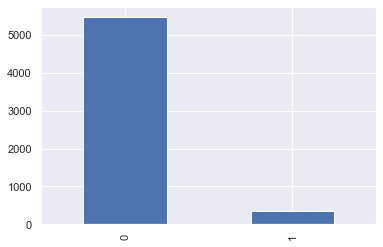

In [ ]:
#see the proportion of data
v_count = dataset["CARAVAN"].value_counts()
print(v_count)
v_count.plot(kind = "bar");

In [ ]:
v_count = dataset["CARAVAN"]
no_caravan = (v_count.value_counts()[0]/v_count.count())*100
print(no_caravan,"% of the customers in train data doesn't have a Caravan Insurance Policy")

94.02267262109241 % of the customers in train data doesn't have a Caravan Insurance Policy


In [ ]:
dataset.columns

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR',
       'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MFALLEEN', 'MFGEKIND',
       'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF',
       'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1',
       'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS',
       'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM',
       'MKOOPKLA', 'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PAANHANG',
       'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'ALEVEN', 'AFIETS',
       'CARAVAN'],
      dtype='object')

Here is what each column indicates:

ID NAME DESCRIPTION 
1 MOSTYPE Customer Subtype
2 MAANTHUI Number of houses
3 MGEMOMV Avg size household
4 MGEMLEEF Avg age
5 MOSHOOFD Customer main type
6 MGODRK Roman catholic
7 MGODPR Protestant ...
8 MGODOV Other religion
9 MGODGE No religion
10 MRELGE Married
11 MRELSA Living together
12 MRELOV Other relation
13 MFALLEEN Singles
14 MFGEKIND Household without children
15 MFWEKIND Household with children
16 MOPLHOOG High level education
17 MOPLMIDD Medium level education
18 MOPLLAAG Lower level education
19 MBERHOOG High status
20 MBERZELF Entrepreneur
21 MBERBOER Farmer
22 MBERMIDD Middle management
23 MBERARBG Skilled labourers
24 MBERARBO Unskilled labourers
25 MSKA Social class A
26 MSKB1 Social class B1
27 MSKB2 Social class B2
28 MSKC Social class C
29 MSKD Social class D
30 MHHUUR Rented house
31 MHKOOP Home owners
32 MAUT1 1 car
33 MAUT2 2 cars
34 MAUT0 No car
35 MZFONDS National Health Service
36 MZPART Private health insurance
37 MINKM30 Income < 30
38 MINK3045 Income 30-45.000
39 MINK4575 Income 45-75.000
40 MINK7512 Income 75-122.000
41 MINK123M Income >123.000
42 MINKGEM Average income
43 MKOOPKLA Purchasing power class
44 PWAPART Contribution private third party insurance see 
45 PWABEDR Contribution third party insurance (firms) ... 
46 PWALAND Contribution third party insurane (agriculture)
47 PPERSAUT Contribution car policies
48 PBESAUT Contribution delivery van policies
49 PMOTSCO Contribution motorcycle/scooter policies
50 PVRAAUT Contribution lorry policies
51 PAANHANG Contribution trailer policies
52 PTRACTOR Contribution tractor policies
53 PWERKT Contribution agricultural machines policies
54 PBROM Contribution moped policies
55 PLEVEN Contribution life insurances
56 PPERSONG Contribution private accident insurance policies
57 PGEZONG Contribution family accidents insurance policies
58 PWAOREG Contribution disability insurance policies
59 PBRAND Contribution fire policies
60 PZEILPL Contribution surfboard policies
61 PPLEZIER Contribution boat policies
62 PFIETS Contribution bicycle policies
63 PINBOED Contribution property insurance policies
64 PBYSTAND Contribution social security insurance policies
65 AWAPART Number of private third party insurance 
66 AWABEDR Number of third party insurance (firms) ... 
67 AWALAND Number of third party insurane (agriculture) 
68 APERSAUT Number of car policies
69 ABESAUT Number of delivery van policies
70 AMOTSCO Number of motorcycle/scooter policies
71 AVRAAUT Number of lorry policies
72 AAANHANG Number of trailer policies
73 ATRACTOR Number of tractor policies
74 AWERKT Number of agricultural machines policies
75 ABROM Number of moped policies
76 ALEVEN Number of life insurances
77 APERSONG Number of private accident insurance policies 
78 AGEZONG Number of family accidents insurance policies 
79 AWAOREG Number of disability insurance policies
80 ABRAND Number of fire policies
81 AZEILPL Number of surfboard policies
82 APLEZIER Number of boat policies
83 AFIETS Number of bicycle policies
84 AINBOED Number of property insurance policies
85 ABYSTAND Number of social security insurance policies 
86 CARAVAN Number of mobile home policies

In [ ]:
# Distinct values in column MOSTYPE and corresponding number of customers 
dataset.MOSTYPE.value_counts()

33    810
8     339
38    339
39    328
9     278
23    251
3     249
36    225
35    214
41    205
31    205
34    182
24    180
13    179
10    165
11    153
32    141
37    132
1     124
6     119
30    118
12    111
22     98
29     86
2      82
25     82
40     71
4      52
27     50
26     48
5      45
7      44
28     25
20     25
18     19
16     16
21     15
17      9
15      5
19      3
Name: MOSTYPE, dtype: int64

**MOSTYPE is the Customer Subtype. Here is what is each of the value in MOSTYPE columns means.**

* 1 High Income, expensive child 
* 2 Very Important Provincials 
* 3 High status seniors 
* 4 Affluent senior apartments 
* 5 Mixed seniors 
* 6 Career and childcare 
* 7 Dinki's (double income no kids) 
* 8 Middle class families 
* 9 Modern, complete families 
* 10 Stable family 
* 11 Family starters 
* 12 Affluent young families 
* 13 Young all american family 
* 14 Junior cosmopolitan 
* 15 Senior cosmopolitans 
* 16 Students in apartments 
* 17 Fresh masters in the city 
* 18 Single youth 
* 19 Suburban youth 
* 20 Etnically diverse 
* 21 Young urban have-nots 
* 22 Mixed apartment dwellers 
* 23 Young and rising 
* 24 Young, low educated 
* 25 Young seniors in the city 
* 26 Own home elderly 
* 27 Seniors in apartments 
* 28 Residential elderly 
* 29 Porchless seniors: no front yard 
* 30 Religious elderly singles 
* 31 Low income catholics 
* 32 Mixed seniors 
* 33 Lower class large families 
* 34 Large family, employed child 
* 35 Village families 
* 36 Couples with teens 'Married with children' 
* 37 Mixed small town dwellers 
* 38 Traditional families 
* 39 Large religous families 
* 40 Large family farms 
* 41 Mixed rurals

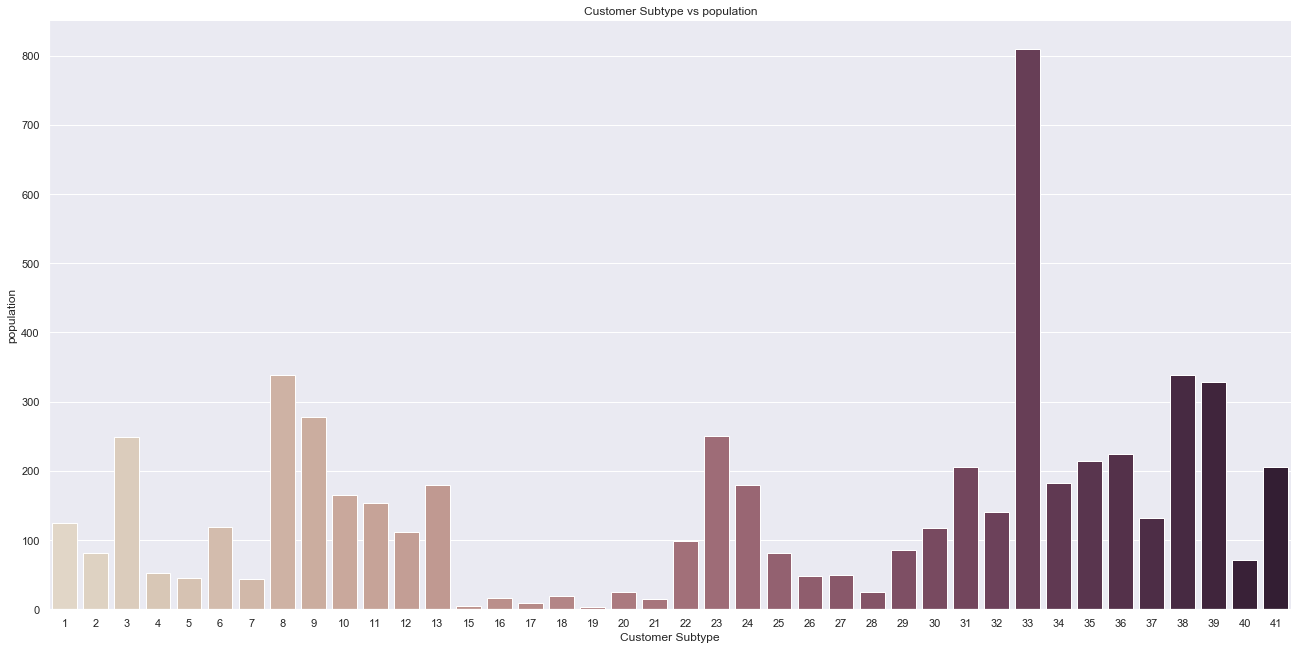

In [ ]:
# bar chart showing numbers of customers by subtype
SD1=dataset.loc[:,"MOSTYPE"]
ax=sns.catplot(x=SD1.index, kind="count", palette="ch:.25", data=SD1, height=9, aspect=2)
ax.set(title="Customer Subtype vs population",xlabel='Customer Subtype', ylabel='population')

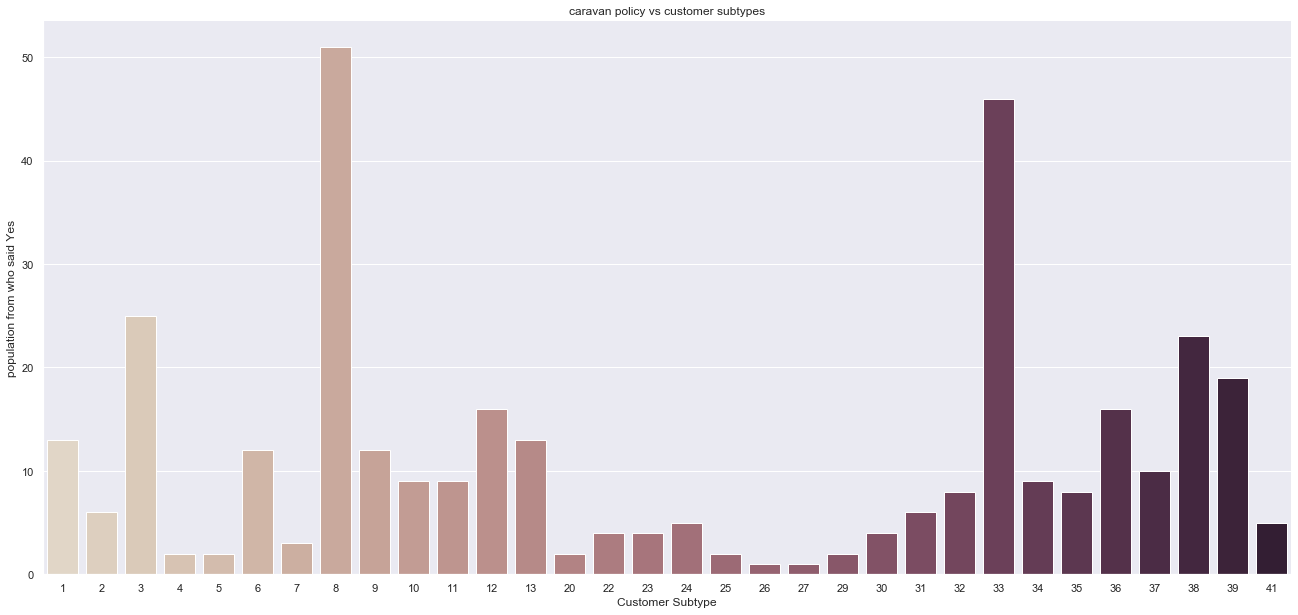

In [ ]:
#Purchased caravan policy vs customer subtypes
db=dataset.loc[dataset['CARAVAN']==1]
SD1=db.loc[:,"MOSTYPE"]
ax=sns.catplot(x=SD1.index, kind="count", palette="ch:.25", data=SD1, height=9, aspect=2)
ax.set(title="caravan policy vs customer subtypes",xlabel='Customer Subtype', ylabel='population from who said Yes')

90.46719340432841 % customer has 1 House
8.673995190656132 % customer has 2 House
0.6698728959120578 % customer has 3 House
0.034352456200618345 % customer has 4 House
0.017176228100309172 % customer has 5 House
0.017176228100309172 % customer has 6 House
0.08588114050154586 % customer has 7 House
0.017176228100309172 % customer has 8 House
0.017176228100309172 % customer has 10 House


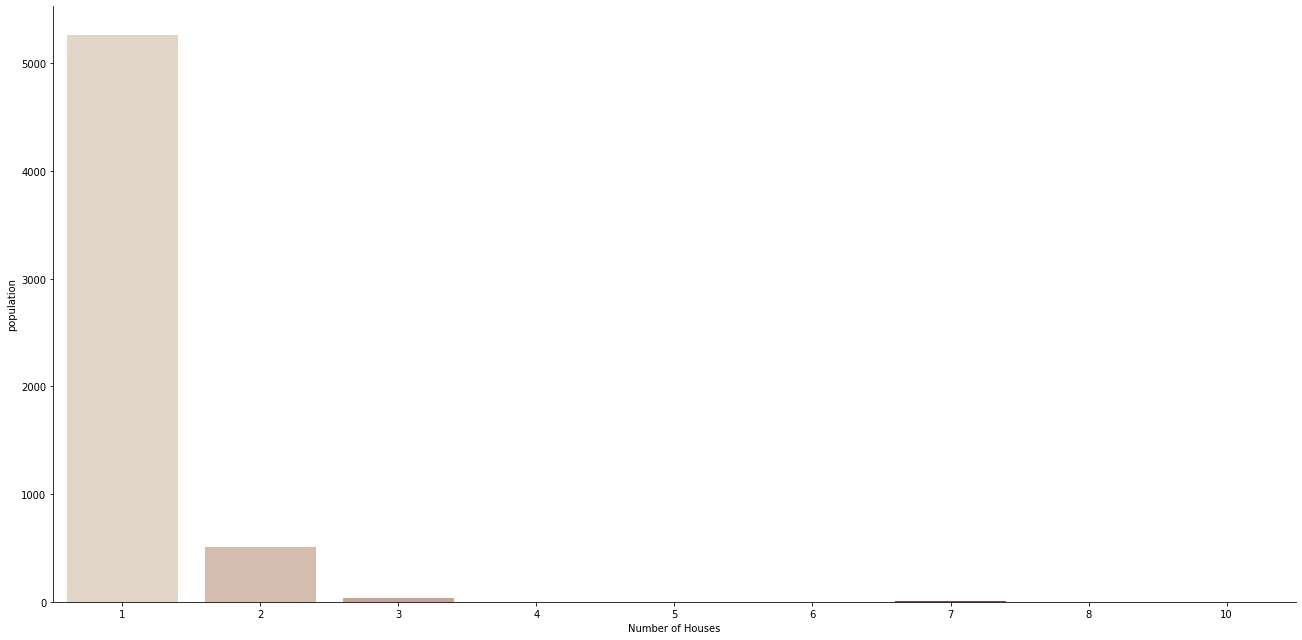

In [ ]:
# distinct values in the column MAANTHUI(Number of Houses) and number of customers
SD2=dataset.loc[:,"MAANTHUI"]
ax=sns.catplot(x=SD2.index, kind="count", palette="ch:.25", data=SD2, height=9, aspect=2)
ax.set(xlabel='Number of Houses', ylabel='population')

for i in range(1,11):
    if i not in dataset.MAANTHUI.value_counts():
        continue
    print((train.MAANTHUI.value_counts()[i]/v_count.count())*100,"% customer has",i, "House")


**MAANTHUI column represents number of houses. As you can see, 90.4 % percent of customers have just one house.**

1    315
2     33
Name: MAANTHUI, dtype: int64


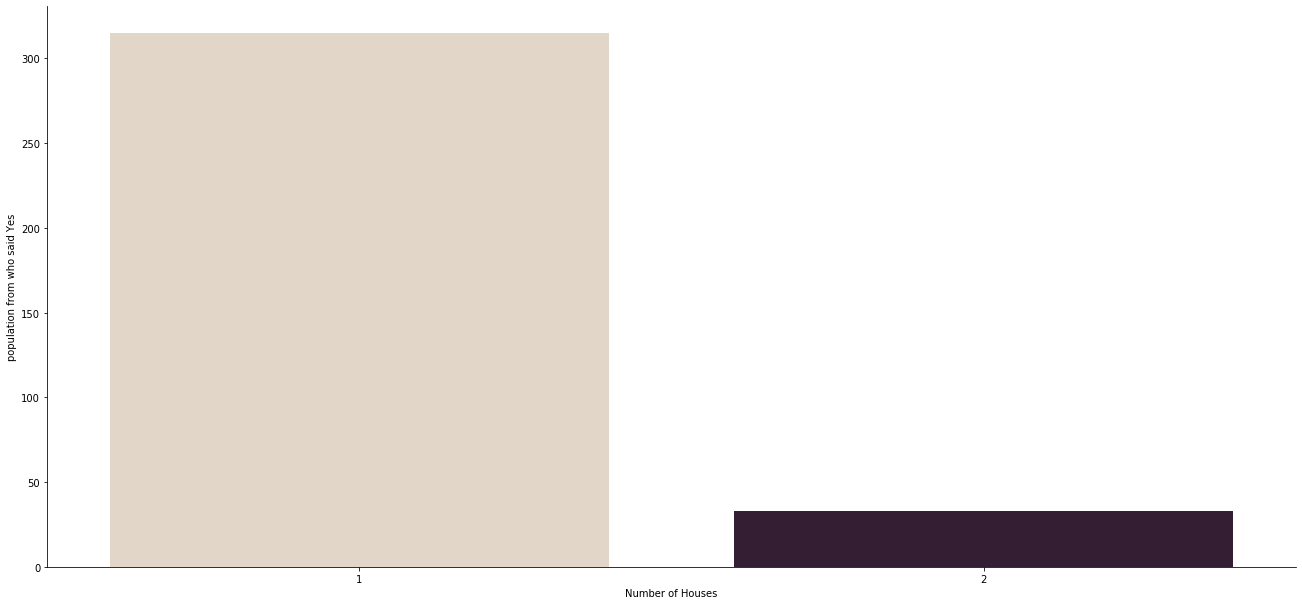

In [ ]:
#Purchased caravan policy vs customers number of houses
print(dataset[dataset.CARAVAN==1].MAANTHUI.value_counts())
db=dataset.loc[dataset['CARAVAN']==1]
SD2=db.loc[:,"MAANTHUI"]
ax=sns.catplot(x=SD2.index, kind="count", palette="ch:.25", data=SD2, height=9, aspect=2)
ax.set(xlabel='Number of Houses', ylabel='population from who said Yes')

**The customers with a Caravan Insurance have only 1 or 2 houses.**

284 Customers has 1 Households
2131 Customers has 2 Households
2646 Customers has 3 Households
693 Customers has 4 Households
68 Customers has 5 Households


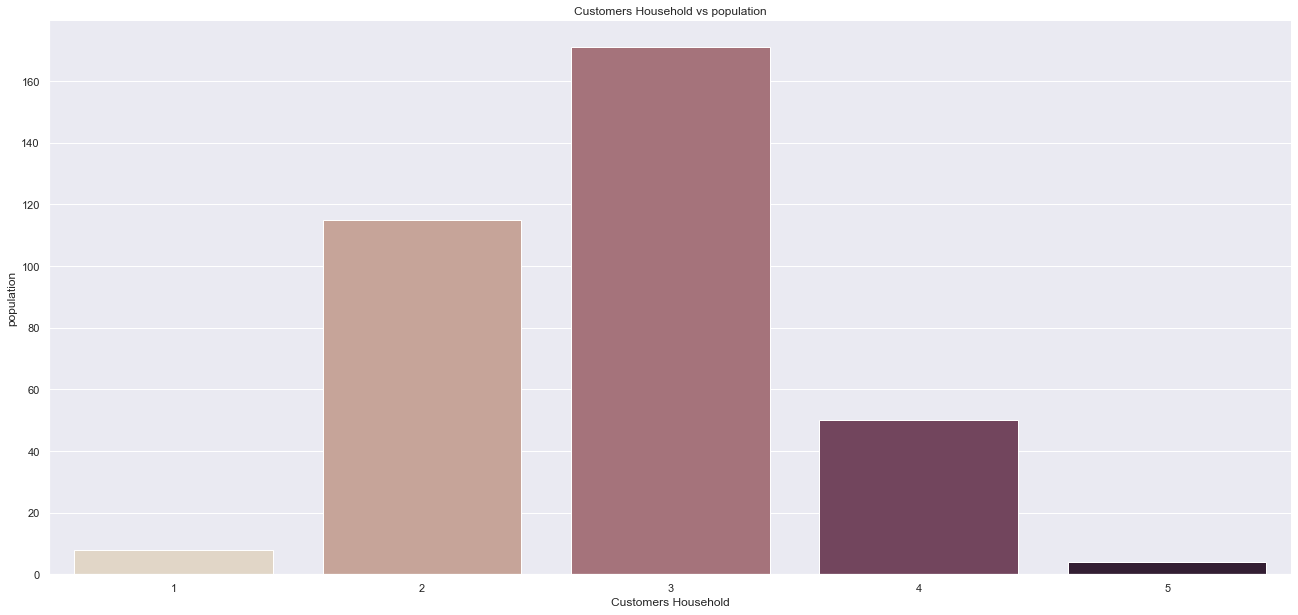

In [ ]:
# distinct values in the column MGEMOMV and number of customers
for i in range(1,10):
    if i not in train.MGEMOMV.value_counts():
        continue
    print(train.MGEMOMV.value_counts()[i],"Customers has",i,"Households")

SD3=dataset.loc[:,"MGEMOMV"]
ax=sns.catplot(x=SD1.index, kind="count", palette="ch:.25", data=SD3, height=9, aspect=2)
ax.set(title="Customers Household vs population",xlabel='Customers Household', ylabel='population')


8 Caravan customers has 1 Households
115 Caravan customers has 2 Households
171 Caravan customers has 3 Households
50 Caravan customers has 4 Households
4 Caravan customers has 5 Households


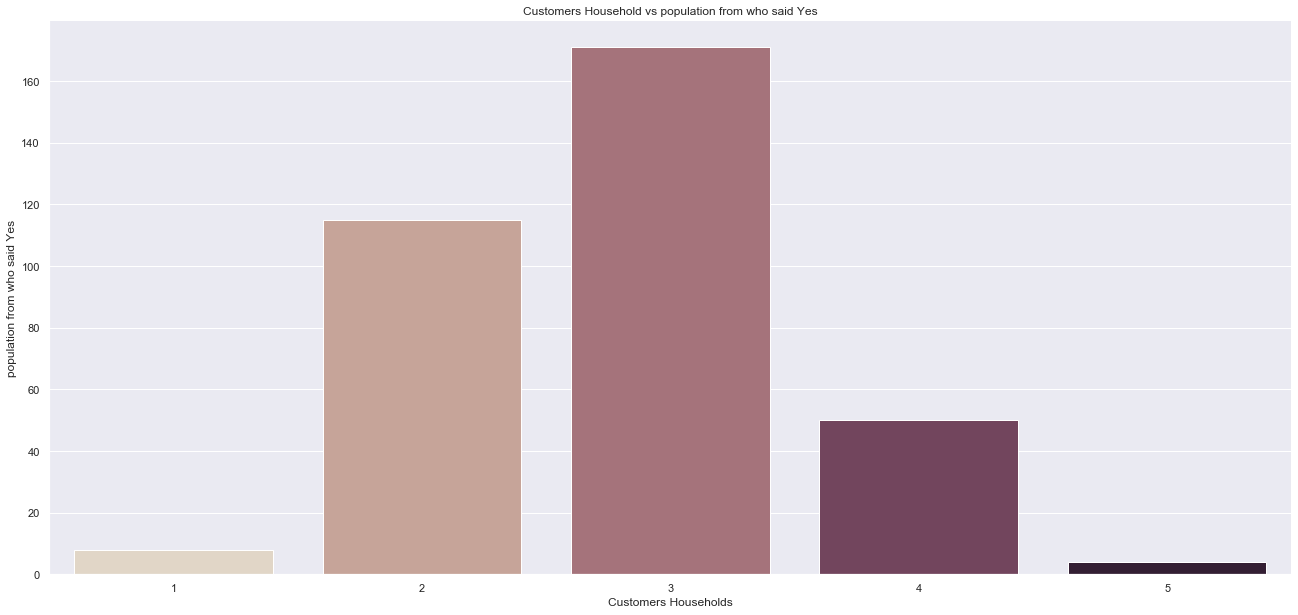

In [ ]:
for i in range(1,10):
    if i not in train[train.CARAVAN==1].MGEMOMV.value_counts():
        continue
    print(train[train.CARAVAN==1].MGEMOMV.value_counts()[i],"Caravan customers has",i,"Households")
    
db=dataset.loc[dataset['CARAVAN']==1]
SD3=db.loc[:,"MGEMOMV"]
ax=sns.catplot(x=SD2.index, kind="count", palette="ch:.25", data=SD3, height=9, aspect=2)
ax.set(title="Customers Household vs population from who said Yes",xlabel='Customers Households', ylabel='population from who said Yes')

74 Customers are between 20-30 years old
1452 Customers are between 30-40 years old
3000 Customers are between 40-50 years old
1073 Customers are between 50-60 years old
193 Customers are between 60-70 years old
30 Customers are between 70-80 years old


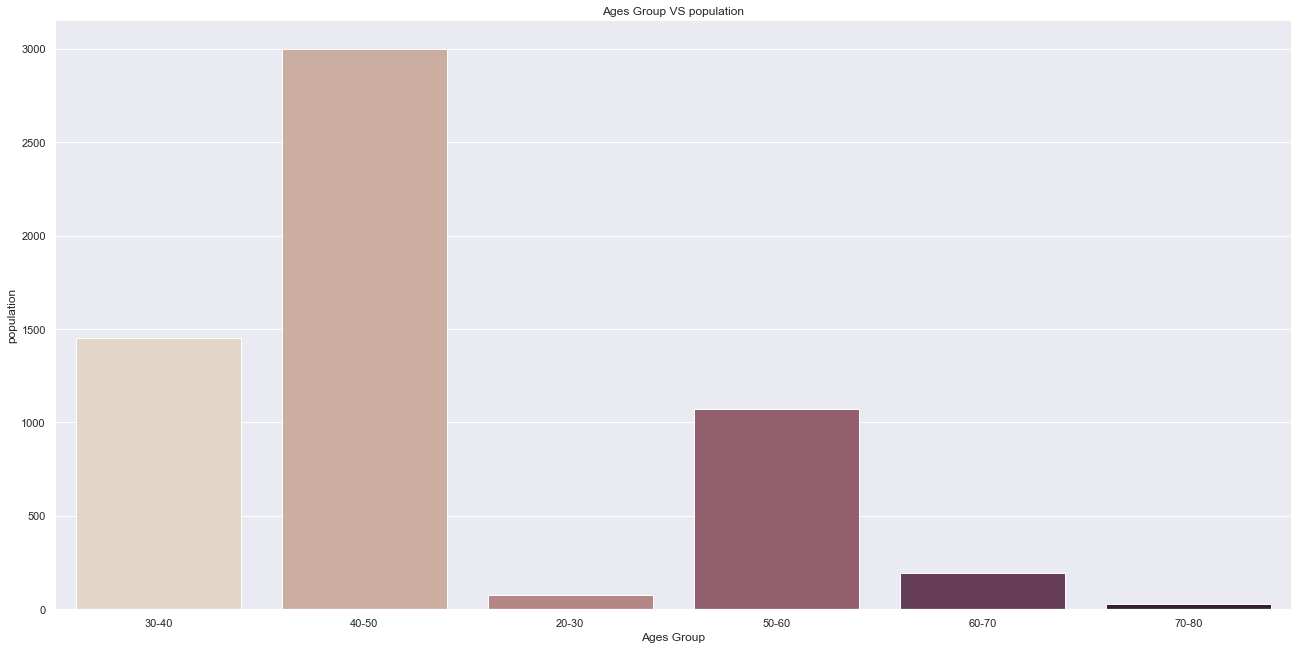

In [ ]:
#MGEMLEEF column represent the age group

for i in range(1,10):
    if i not in train.MGEMLEEF.value_counts():
        continue
    def calcAge(i):
        if i == 1:
            print (p, "Customers are between 20-30 years old")
        elif i == 2:
            print(p, "Customers are between 30-40 years old")
        elif i == 3 :
            print(p, "Customers are between 40-50 years old")
        elif i == 4 :
            print(p, "Customers are between 50-60 years old")
        elif i == 5 :
            print(p, "Customers are between 60-70 years old")
        elif i == 6 :
            print(p, "Customers are between 70-80 years old")
            
    p= train.MGEMLEEF.value_counts()[i]
    calcAge(i)
    
age_classes = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
SD4= dataset.loc[:,"MGEMLEEF"]
SD4 = SD4.apply(lambda x : age_classes[x-1])
ax=sns.catplot(x=SD4.index, kind="count", palette="ch:.25", data=SD4, height=9, aspect=2)
ax.set(title="Ages Group VS population",xlabel='Ages Group', ylabel='population')


**Most customers with Caravan insurance have a average household of 2,3 or 4 people.**

**Purchased caravan policy vs age's classes**

1 Caravan Customers are between 20-30 years old
87 Caravan Customers are between 30-40 years old
183 Caravan Customers are between 40-50 years old
64 Caravan Customers are between 50-60 years old
12 Caravan Customers are between 60-70 years old
1 Caravan Customers are between 70-80 years old


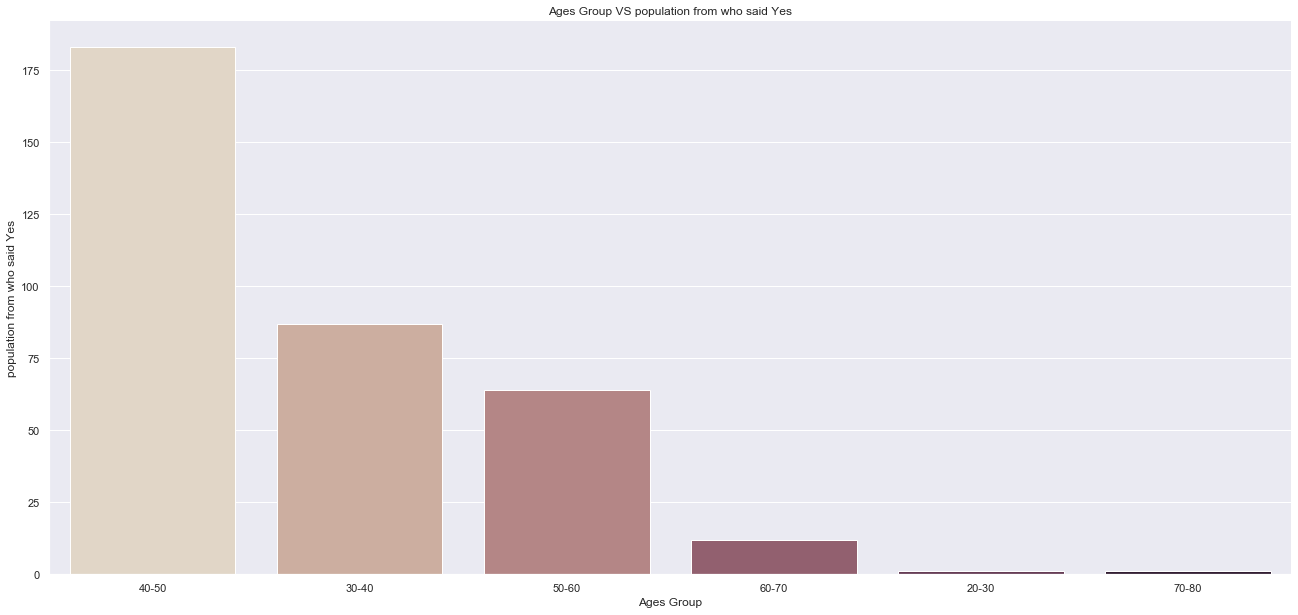

In [ ]:
for i in range(1,10):
    if i not in dataset[dataset.CARAVAN==1].MGEMLEEF.value_counts():
        continue
    def calcAge(i):
        if i == 1:
            print (p,"Caravan Customers are between 20-30 years old")
        elif i == 2:
            print(p,"Caravan Customers are between 30-40 years old")
        elif i == 3 :
            print(p, "Caravan Customers are between 40-50 years old")
        elif i == 4 :
            print(p,"Caravan Customers are between 50-60 years old")
        elif i == 5 :
            print(p,"Caravan Customers are between 60-70 years old")
        elif i == 6 :
            print(p,"Caravan Customers are between 70-80 years old")
            
    p = train[train.CARAVAN==1].MGEMLEEF.value_counts()[i]
    calcAge(i)


age_classes = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
purchased = dataset.loc[dataset["CARAVAN"] == 1, "MGEMLEEF"]
purchased = purchased.apply(lambda x : age_classes[x-1])
#print(purchased)
ax=sns.catplot(x=purchased.index, kind="count", palette="ch:.25", data=purchased, height=9, aspect=2)
ax.set(title="Ages Group VS population from who said Yes",xlabel='Ages Group', ylabel='population from who said Yes')

**So most customers with a Caravan insurance are between 30 to 60 years of age**

552 Customers are Successful hedonists
502 Customers are Driven Growers
886 Customers are Average Family
52 Customers are Career Loners
569 Customers are Career Loners
205 Customers are Cruising Seniors
550 Customers are Retired and Religeous
1563 Customers are Family with grown ups
667 Customers are Conservative families
276 Customers are Farmers


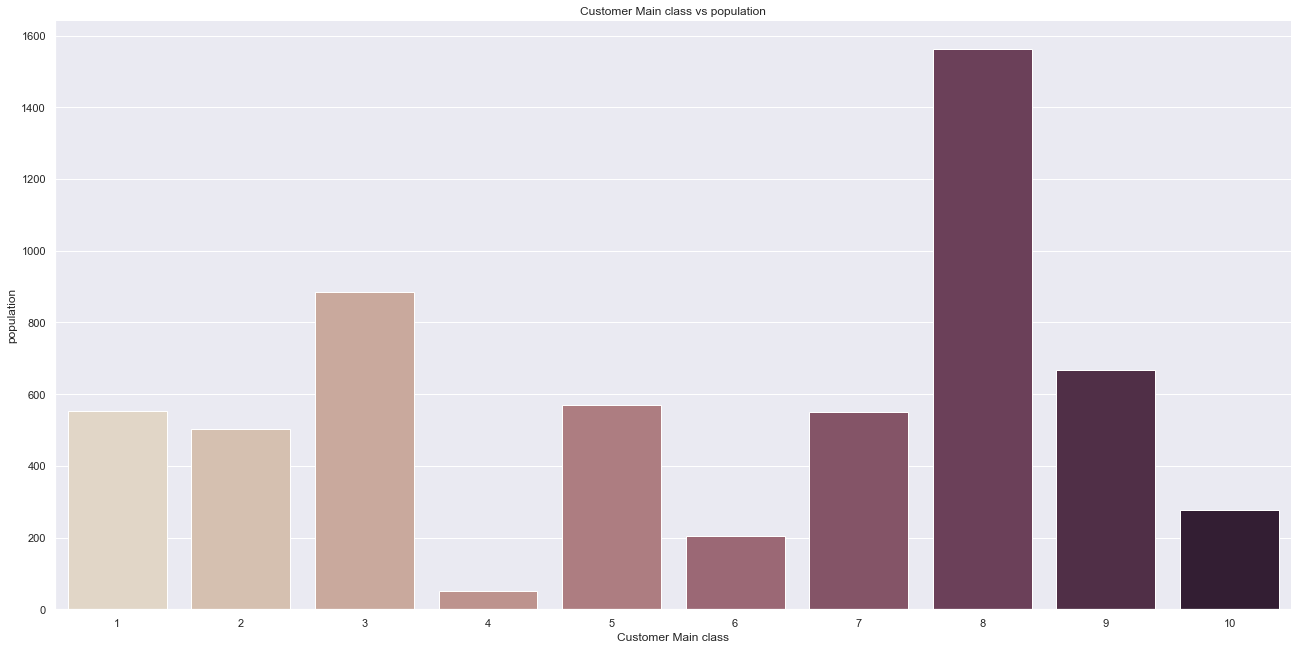

In [ ]:
# MOSHOOFD represent the customer mail class 
for i in range(1,11):
    if i not in train.MOSHOOFD.value_counts():
        continue
    def calcAge(i):
        if i == 1:
            print (p, "Customers are Successful hedonists")
        elif i == 2:
            print(p, "Customers are Driven Growers")
        elif i == 3 :
            print(p, "Customers are Average Family")
        elif i == 4 :
            print(p, "Customers are Career Loners")
        elif i == 5 :
            print(p, "Customers are Career Loners")
        elif i == 6 :
            print(p, "Customers are Cruising Seniors")
        elif i == 7 :
            print(p, "Customers are Retired and Religeous")
        elif i == 8 :
            print(p, "Customers are Family with grown ups")
        elif i == 9 :
            print(p, "Customers are Conservative families")
        elif i == 10 :
            print(p, "Customers are Farmers")
            
    p = train.MOSHOOFD.value_counts()[i]
    calcAge(i)

SD3=train.loc[:,"MOSHOOFD"]
ax=sns.catplot(x=SD1.index, kind="count", palette="ch:.25", data=SD3, height=9, aspect=2)
ax.set(title="Customer Main class vs population",xlabel='Customer Main class', ylabel='population')

48 Caravan Customers are Successful hedonists
66 Caravan Customers are Driven Growers
59 Caravan Customers are Average Family
15 Caravan Customers are Career Loners
4 Caravan Customers are Cruising Seniors
20 Caravan Customers are Retired and Religeous
89 Caravan Customers are Family with grown ups
42 Caravan Customers are Conservative families
5 Caravan Customers are Farmers


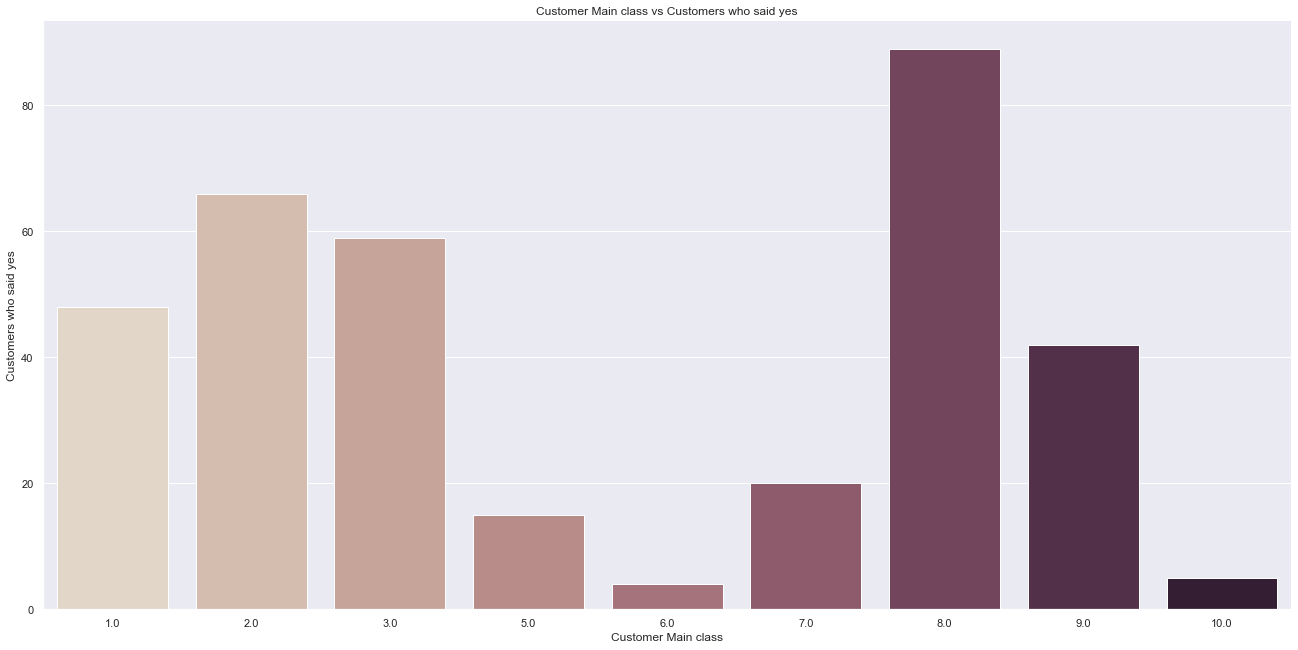

In [ ]:
for i in range(1,11):
    if i not in train[train.CARAVAN==1].MOSHOOFD.value_counts():
        continue
    def calcAge(i):
        if i == 1:
            print (p, "Caravan Customers are Successful hedonists")
        elif i == 2:
            print(p, "Caravan Customers are Driven Growers")
        elif i == 3 :
            print(p, "Caravan Customers are Average Family")
        elif i == 4 :
            print(p, "Caravan Customers are Career Loners")
        elif i == 5 :
            print(p, "Caravan Customers are Career Loners")
        elif i == 6 :
            print(p, "Caravan Customers are Cruising Seniors")
        elif i == 7 :
            print(p, "Caravan Customers are Retired and Religeous")
        elif i == 8 :
            print(p, "Caravan Customers are Family with grown ups")
        elif i == 9 :
            print(p, "Caravan Customers are Conservative families")
        elif i == 10 :
            print(p, "Caravan Customers are Farmers")
            
    p = train[train.CARAVAN==1].MOSHOOFD.value_counts()[i]
    calcAge(i)

SD3=train.loc[train['CARAVAN']==1,"MOSHOOFD"]
ax=sns.catplot(x=SD1.index, kind="count", palette="ch:.25", data=SD3, height=9, aspect=2)
ax.set(title="Customer Main class vs Customers who said yes",xlabel='Customer Main class', ylabel='Customers who said yes')


#### Purchased caravan policy vs work####

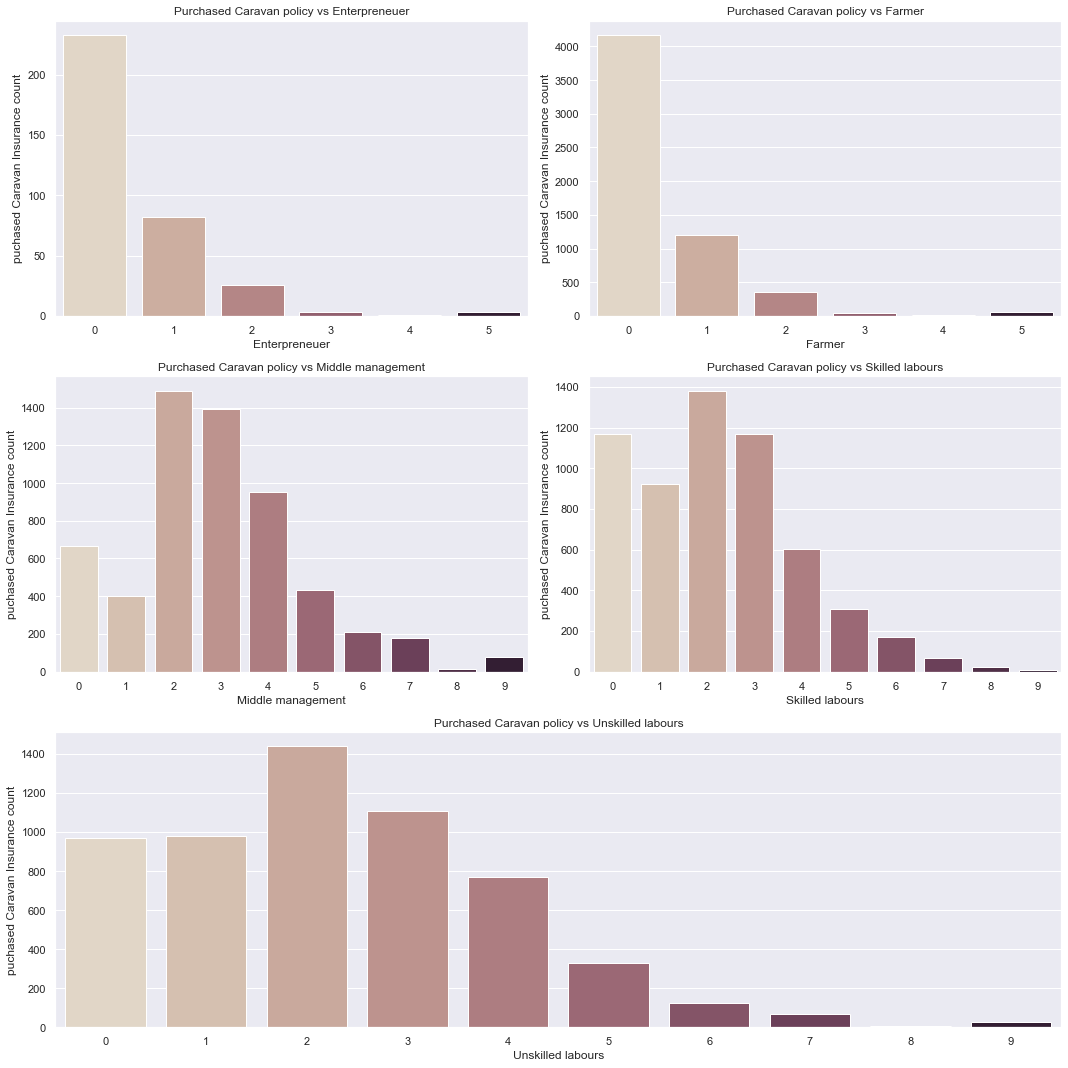

In [ ]:
from matplotlib.gridspec import GridSpec
purchased_df = dataset.loc[dataset.CARAVAN == 1]
enterpreneuer = purchased_df.loc[:,"MBERZELF"]
farmer = dataset.loc[:,"MBERZELF"]
middle_management = dataset.loc[:,"MBERMIDD"]
skilled_labours = dataset.loc[:,"MBERARBG"]
unskilled_labours = dataset.loc[:,"MBERARBO"]

gs = GridSpec(3, 2)
plt.figure(figsize=(15,15))
sns.set(style="darkgrid")

ax = plt.subplot(gs[0,0])
sns.countplot(x=enterpreneuer.index,data=enterpreneuer,palette="ch:.25",ax=ax)
ax.set(title="Purchased Caravan policy vs Enterpreneuer",xlabel = "Enterpreneuer", ylabel="puchased Caravan Insurance count")

ax1 = plt.subplot(gs[0,1])
sns.countplot(x=farmer.index,data=farmer,palette="ch:.25",ax=ax1)
ax1.set(title="Purchased Caravan policy vs Farmer",xlabel = "Farmer", ylabel="puchased Caravan Insurance count")

ax2 = plt.subplot(gs[1,0])
sns.countplot(x=middle_management.index,data=middle_management,palette="ch:.25",ax=ax2)
ax2.set(title="Purchased Caravan policy vs Middle management",xlabel = "Middle management", ylabel="puchased Caravan Insurance count")

ax3 = plt.subplot(gs[1,1])
sns.countplot(x=skilled_labours.index,data=skilled_labours,palette="ch:.25",ax=ax3)
ax3.set(title="Purchased Caravan policy vs Skilled labours",xlabel = "Skilled labours", ylabel="puchased Caravan Insurance count")

ax4 = plt.subplot(gs[2,:])
sns.countplot(x=unskilled_labours.index,data=unskilled_labours,palette="ch:.25",ax=ax4)
ax4.set(title="Purchased Caravan policy vs Unskilled labours",xlabel = "Unskilled labours", ylabel="puchased Caravan Insurance count")

plt.tight_layout()
plt.show()


**we can see that the majority of labours are qualified (less than 36% of unskilled labourers) with less than 20% entreprenors , and most of them live in the city ( since they are not farmers ),less than 50% are unskilled labourers**

**Purchased caravan policy vs education level**

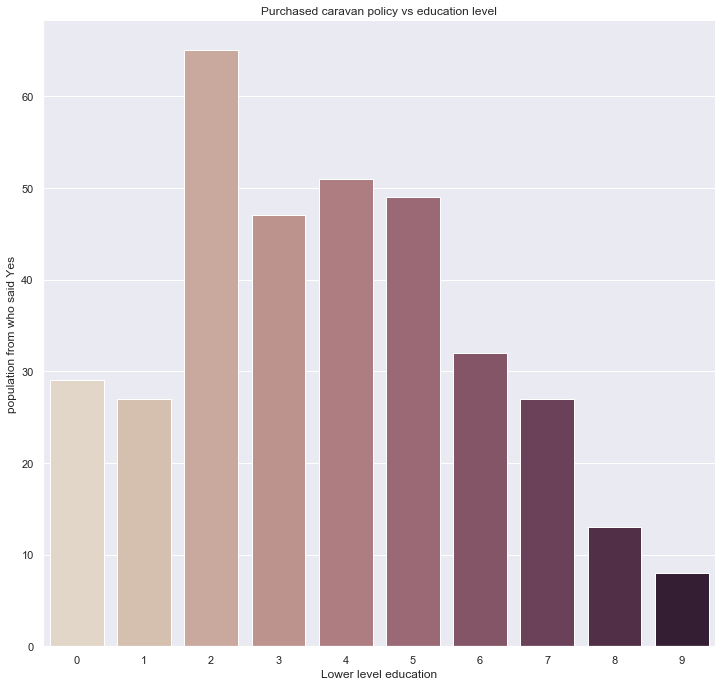

In [ ]:
SD18=db.loc[:,"MOPLLAAG"]
sns.set(style="darkgrid")
ax=sns.catplot(x=SD18.index, kind="count", palette="ch:.25", data=SD18,height=10);
ax.set(title='Purchased caravan policy vs education level',xlabel='Lower level education', ylabel='population from who said Yes')
plt.show()


#### Purchased caravan policy vs average income ####

***It seems that the avg income column describes the percentage of customers near the average income. So we will convert it into a real value of income using the variables "Income < 30.000", "Income 30-45.000"... which describe the percentage of people in a certain range of income.***

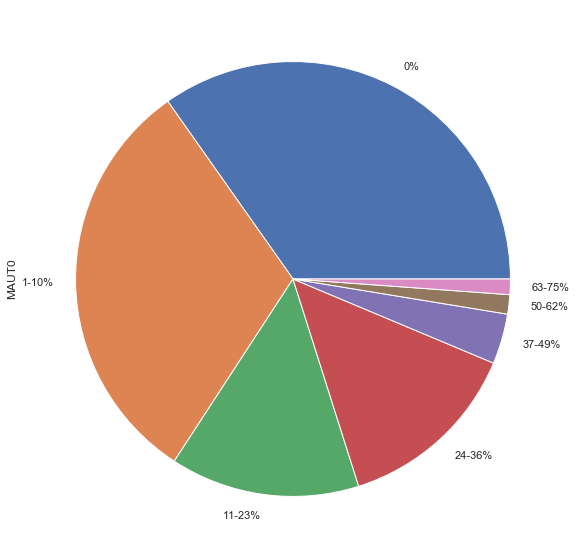

In [ ]:
dataset['MAUT0'].head()

plt.figure(figsize=(12,10))
pourc = ['0%', '1-10%', '11-23%', '24-36%', '37-49%', '50-62%', '63-75%', '76-88%', '89-99%', '100%']
dataset[dataset['CARAVAN'] == 1]['MAUT0'].value_counts().plot(kind = 'pie', labels=pourc);

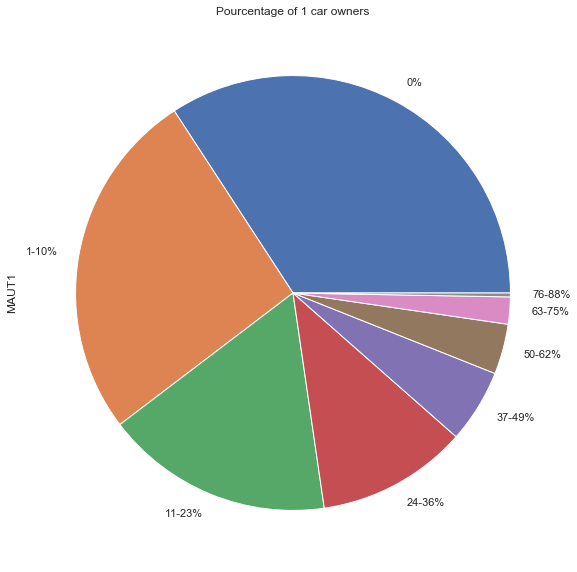

In [ ]:
plt.figure(figsize=(12, 10))
pourc = ['0%', '1-10%', '11-23%', '24-36%', '37-49%', '50-62%', '63-75%', '76-88%', '89-99%', '100%']
dataset[dataset['CARAVAN'] == 1]['MAUT1'].value_counts().plot(kind = 'pie', labels=pourc, 
                                                              title="Pourcentage of 1 car owners");

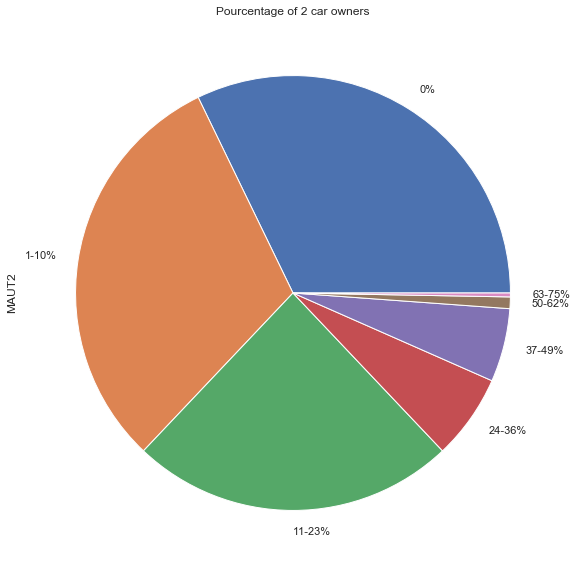

In [ ]:
plt.figure(figsize=(12, 10))
pourc = ['0%', '1-10%', '11-23%', '24-36%', '37-49%', '50-62%', '63-75%', '76-88%', '89-99%', '100%']
dataset[dataset['CARAVAN'] == 1]['MAUT2'].value_counts().plot(kind = 'pie', labels=pourc, 
                                                              title="Pourcentage of 2 car owners");

## Test Train Split ##

In [ ]:
# Shuffle the data randomly. Random seed already set above.
shuffled_df_ds = dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
# Just to rule it out, try a non-manual split using train_test_split().
X_fi = shuffled_df_ds.drop(['CARAVAN'], axis=1)
y_fi = shuffled_df_ds['CARAVAN']
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.20, random_state=9)

In [ ]:
# Examine the split.
print(y_test_fi.value_counts())
print(y_train_fi.value_counts())

0    1106
1      59
Name: CARAVAN, dtype: int64
0    4368
1     289
Name: CARAVAN, dtype: int64


In [ ]:
# Logistic Regression.
lr_fi = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_fi = GridSearchCV(lr_fi, parameters, cv=10)
clf_lr_fi.fit(X_train_fi, y_train_fi)
best_lr2_fi = clf_lr_fi.best_estimator_
y_hat_lrfi = best_lr2_fi.predict(X_test_fi)
confusion_matrix(y_test_fi, y_hat_lrfi, labels=[1,0])

array([[   0,   59],
       [   0, 1106]])

In [ ]:
# Examine metrics.
y_hat_proba_fi = best_lr2_fi.predict_proba(X_test_fi)
lr_fi_fpr, lr_fi_tpr, thresholds_fi = roc_curve(y_test_fi, y_hat_lrfi[:,1])
lr_fi_roc_auc = auc(lr_fi_fpr, lr_fi_tpr)
print('AUC: %0.2f' % lr_fi_roc_auc)
print(classification_report(y_test_fi, y_hat_lrfi))

IndexError: too many indices for array

In [ ]:
# Shuffle the data randomly. Random seed already set above.
shuffled_df = train.sample(frac=1).reset_index(drop=True)

In [ ]:
# Recall dataset imbalance.
shuffled_df['CARAVAN'].value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

In [ ]:
# Get ratio of 1s to 0s.
ratio_ones = shuffled_df['CARAVAN'].value_counts()[1]/(shuffled_df['CARAVAN'].value_counts()[0] + 
                                                        shuffled_df['CARAVAN'].value_counts()[1])

**We want our training and test data to respect the imbalance in our dataset with with respect to the outcome variable's value. We'll do an 80%/20% split, with 80% for training and 20% for test.**

In [ ]:
# Recall size of dataset.
shuffled_df.shape

(5822, 86)

In [ ]:
# Get size of training and test sets.
train_size = int(shuffled_df.shape[0]*.80)
test_size = shuffled_df.shape[0]-train_size
print('Training set size: %i' % train_size)
print('Test set size: %i' % test_size)

Training set size: 4657
Test set size: 1165


In [ ]:
# Get number of 1s and 0s in Purchase column for training set.
train_num_ones = math.ceil(train_size*(ratio_ones))
train_num_zeros = train_size-train_num_ones
print('Training set 1s: %i' % train_num_ones)
print('Training set 0s: %i' % train_num_zeros)

Training set 1s: 279
Training set 0s: 4378


In [ ]:
# Get number of 1s and 0s in Purchase column for test set.
test_num_ones = int(test_size*(ratio_ones))
test_num_zeros = test_size-test_num_ones
print('Test set 1s: %i' % test_num_ones)
print('Test set 0s: %i' % test_num_zeros)

Test set 1s: 69
Test set 0s: 1096


In [ ]:
# Split shuffled data according to the proper ratios.
test_df = shuffled_df[shuffled_df['CARAVAN'] == 1][:test_num_ones]
train_df = shuffled_df[shuffled_df['CARAVAN'] == 1][test_num_ones:]
test_df = test_df.append(shuffled_df[shuffled_df['CARAVAN'] == 0][:test_num_zeros])
train_df = train_df.append(shuffled_df[shuffled_df['CARAVAN'] == 0][test_num_zeros:])

In [ ]:
# Verify that the split went according to plan.
print('Test df counts: ','\n',test_df['CARAVAN'].value_counts())
print('Train df counts: ','\n',train_df['CARAVAN'].value_counts())

Test df counts:  
 0    1096
1      69
Name: CARAVAN, dtype: int64
Train df counts:  
 0    4378
1     279
Name: CARAVAN, dtype: int64


In [ ]:
# Reset training and test dataset indexes.
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Split training set into features X and label y.
y_train = train_df['CARAVAN']
X_train = train_df.drop(['CARAVAN'], axis=1)

In [ ]:
# Split test set into features X and label y.
y_test = test_df['CARAVAN']
X_test = test_df.drop(['CARAVAN'], axis=1)

## Classify ##
### Logistic Regression ###

Logistic Regression (aka logit, MaxEnt) classifier.
1. solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’} - Solver refers to the optimization method to use to find the optimum of the objective function.
 1. newton-cg - the nonlinear conjugate gradient method generalizes the conjugate gradient method to nonlinear optimization. The minimum of f(x) is obtained when the gradient is 0.
 2. lbfgs - Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm. The algorithm's target problem is to minimise f(x) over unconstrained values of the real-vector X  where f is a differentiable scalar function.
 3. LIBLINEAR is a linear classifier for data with millions of instances and features. It supports

    * L2-regularized classifiers 
    * L2-loss linear SVM, L1-loss linear SVM, and logistic regression (LR)
    * L1-regularized classifiers (after version 1.4) 
    * L2-loss linear SVM and logistic regression (LR)
    * L2-regularized support vector regression (after version 1.9) 
    * L2-loss linear SVR and L1-loss linear SVR.
   
      i) Main features of LIBLINEAR include

        * Multi-class classification: 1) one-vs-the rest, 2) Crammer & Singer
        * Cross validation for model evaulation
        * Automatic parameter selection
        * Probability estimates (logistic regression only)
        * Weights for unbalanced data
 4. Stochastic Average Gradient (SAG) method, as well as several related methods, for the problem of L2-regularized logistic regression with a finite training set
 5. SAGA - Which handle both multinomial loss and L1 penalty

2. fit_intercept : bool, default: True, fit_intercept=False sets the y-intercept to 0. If fit_intercept=True, the y-intercept will be determined by the line of best fit.

In [ ]:
# Classify with Logistic Regression.
lr = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr = GridSearchCV(lr, parameters, cv=10)
clf_lr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Find the best of our logistic regression models.
best_lr = clf_lr.best_estimator_
best_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make predictions based on our best model.
y_hat_lr = best_lr.predict(X_test)

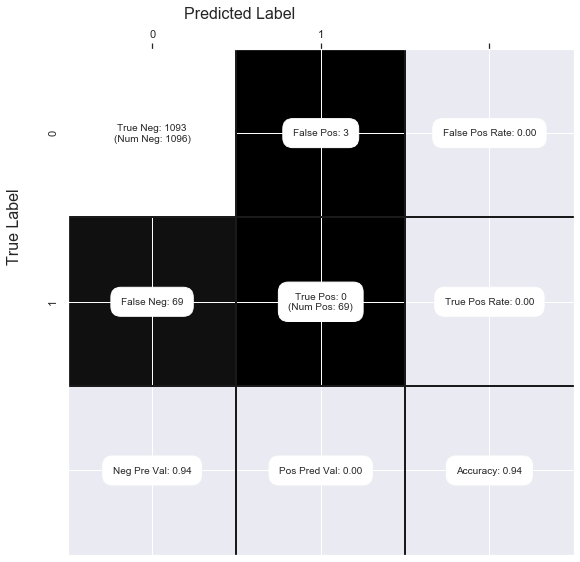

In [ ]:
# Examine confusion matrix for best logistic regression model.
cm = confusion_matrix(y_test, y_hat_lr)
show_confusion_matrix(cm)

In [ ]:
# Get ROC curve and AUC.
y_hat_proba = best_lr.predict_proba(X_test)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

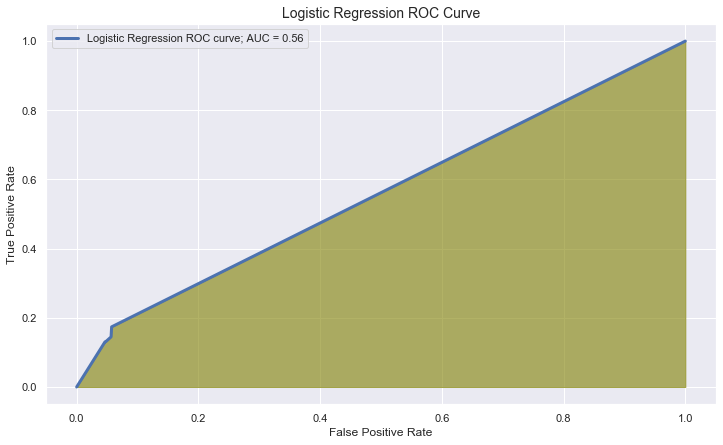

In [ ]:
# Plot ROC curve and AUC for our logistic regression model.
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr, lr_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(lr_fpr, lr_tpr, linewidth=3, label='Logistic Regression ROC curve; AUC = %0.2f' % lr_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

In [ ]:
# Examine other metrics.
print(classification_report(y_test, y_hat_lr))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.88      0.94      0.91      1165



***Since we want to correctly classify the 1s, we can see our model isn't doing terribly well.***

In [ ]:
# Just to rule it out, try a non-manual split using train_test_split().
X = shuffled_df.drop(['CARAVAN'], axis=1)
y = shuffled_df['CARAVAN']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=9)

In [ ]:
# Examine the split.
print(y_test2.value_counts())
print(y_train2.value_counts())

0    1093
1      72
Name: CARAVAN, dtype: int64
0    4381
1     276
Name: CARAVAN, dtype: int64


In [ ]:
# Logistic Regression.
lr2 = LogisticRegression()
parameters2 = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr2 = GridSearchCV(lr2, parameters2, cv=10)
clf_lr2.fit(X_train2, y_train2)
best_lr2 = clf_lr2.best_estimator_
y_hat_lr2 = best_lr2.predict(X_test2)
confusion_matrix(y_test2, y_hat_lr2, labels=[1,0])

array([[   1,   71],
       [   0, 1093]])

***Though the results depend on the random seed, when we didn't explicitly preserve the ratio of 1s to 0s in the training and test data, our model correctly classified a few more data points. But taking into account the variation depending on the random seed, we can see our model is performing roughly the same as before***

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

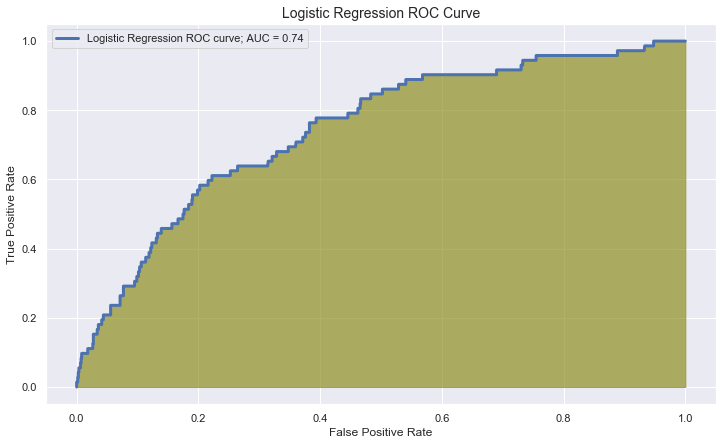

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba2 = best_lr2.predict_proba(X_test2)
lr_fpr2, lr_tpr2, thresholds2 = roc_curve(y_test2, y_hat_proba2[:,1])
lr_roc_auc2 = auc(lr_fpr2, lr_tpr2)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr2, lr_tpr2, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(lr_fpr2, lr_tpr2, linewidth=3, label='Logistic Regression ROC curve; AUC = %0.2f' % lr_roc_auc2)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

In [ ]:
# Examine other metrics.
print(classification_report(y_test2, y_hat_lr2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1093
           1       1.00      0.01      0.03        72

    accuracy                           0.94      1165
   macro avg       0.97      0.51      0.50      1165
weighted avg       0.94      0.94      0.91      1165



***We have a slightly better AUC score here, and our other metrics are up a bit as well. Still, we'll continue to use our original, carefully split training and test data. All in all, we are not correctly classifying 1s very well at all so far.***

### K Nearest Neighbors ###

In [ ]:
# Classify with K-NN.
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn = GridSearchCV(knn, parameters, cv=10)
clf_knn.fit(X_train, y_train)
# Find the best of our K-NN models.
best_knn = clf_knn.best_estimator_
# Make predictions based on our best model.
y_hat_knn = best_knn.predict(X_test)
# Examine confusion matrix for best K-NN model.
confusion_matrix(y_test, y_hat_knn, labels=[1,0])

NameError: ignored

***We have slightly more correct negative classifications than with Logistic Regression on this dataset but `0` correct positives.***

In [ ]:
# Examine other metrics.
print(classification_report(y_test, y_hat_knn))

NameError: ignored

***Our other metrics are just as bad as before.***

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_knn = best_knn.predict_proba(X_test)
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_hat_proba_knn[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr, knn_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(knn_fpr, knn_tpr, linewidth=3, label='K Nearest Neighbors ROC curve; AUC = %0.2f' % knn_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors ROC Curve', size=14)

Our AUC score is a bit worse as well.

***While our precision is down, our recall and f1-score are up. Again, since we want to predict positives, this might be an acceptable trade-off. Our positives are our customers that will ultimately buy Caravan insurance. In this scenario, false negatives are more harmful than false positives. For false negatives, we miss the opportunity to, say, advertise to a potential customer, who may have yielded large profits had they bought the insurance. For false positives, we might spend a small amount of money advertising to someone who ultimately does not buy the insurance. By this reasoning, a higher recall is the priority, even if it means a slightly lower precision.***

***Still, we have plenty of room to improve our model.***

### Decision Tree Classifier ###
criterion : string, optional (default=”gini”). The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

splitter : string, optional (default=”best”). The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [ ]:
# Classify with decision tree.

dt = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'splitter' : ['random','best' ]}
clf_dt = GridSearchCV(dt, parameters, cv=10)
clf_dt.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['random', 'best']},
             pre_d

In [ ]:
# Find the best of our logistic regression models.
best_dt = clf_dt.best_estimator_
best_dt

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
# Make predictions based on our best model.
y_dt= best_dt.predict(X_test)

In [ ]:
# Examine confusion matrix for best decision tree classification model.
confusion_matrix(y_test, y_dt, labels=[1,0])

array([[   9,   60],
       [  52, 1044]])

In [ ]:
# Get ROC curve and AUC.
y_hat_proba = best_dt.predict_proba(X_test)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

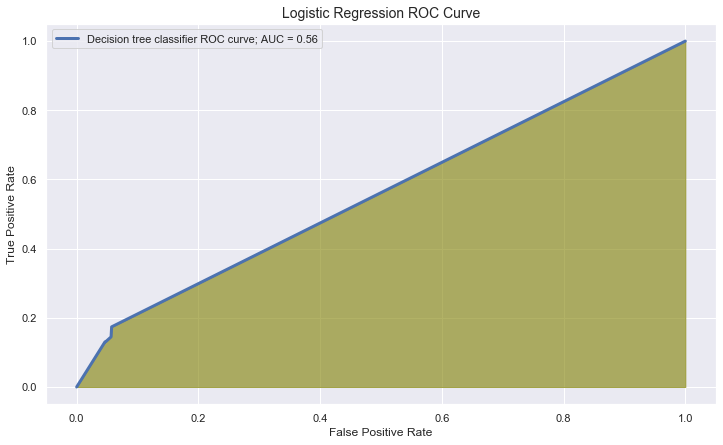

In [ ]:
# Plot ROC curve and AUC for our logistic regression model.
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr, lr_tpr, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(lr_fpr, lr_tpr, linewidth=3, label='Decision tree classifier ROC curve; AUC = %0.2f' % lr_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

In [ ]:
# Examine other metrics.
print(classification_report(y_test, y_dt))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1096
           1       0.15      0.13      0.14        69

    accuracy                           0.90      1165
   macro avg       0.55      0.54      0.54      1165
weighted avg       0.90      0.90      0.90      1165



### Support Vector Classification ###

In [ ]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc.fit(X_train, y_train)
# Find the best of our SVC models.
best_svc = clf_svc.best_estimator_
# Make predictions based on our best model.
y_svc_pred = best_svc.predict(X_test)
# Examine confusion matrix for best SVC model.
confusion_matrix(y_test, y_svc_pred, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [ ]:
# Examine metrics.
y_hat_proba = best_svc.predict_proba(X_test)
svc_fpr, svc_tpr, thresholds = roc_curve(y_test, y_hat_proba[:,1])
svc_roc_auc = auc(svc_fpr, svc_tpr)
print('AUC: %0.2f' % svc_roc_auc)
print(classification_report(y_test, y_svc_pred))

### Normalize the Data and Run Models Again ###
So far, we have been working with un-normalized data. Now, we'll normalize our data and see if our models perform any better.

In [ ]:
# Define a scaler for normalizing the data.
scaler = StandardScaler()

In [ ]:
# Get scaled data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression ####

In [ ]:
# Logistic regression on scaled, ratio-preserved data.
lr_scaled = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_scaled = GridSearchCV(lr_scaled, parameters, cv=10)
clf_lr_scaled.fit(X_train_scaled, y_train)
best_lr_scaled = clf_lr_scaled.best_estimator_
y_hat_lr_scaled = best_lr_scaled.predict(X_test_scaled)
print(confusion_matrix(y_test, y_hat_lr_scaled, labels=[1,0]))

[[   0   69]
 [   2 1094]]


In [ ]:
# Examine metrics.
y_hat_proba_scaled = best_lr_scaled.predict_proba(X_test_scaled)
lr_fpr_scaled, lr_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
lr_roc_auc_scaled = auc(lr_fpr_scaled, lr_tpr_scaled)
print('AUC: %0.2f' % lr_roc_auc_scaled)
print(classification_report(y_test, y_hat_lr_scaled))

AUC: 0.77
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.88      0.94      0.91      1165



This performs no better than before.

#### K Nearest Neighbors ####

In [ ]:
# Classify with K-NN.
knn_scaled = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_scaled = GridSearchCV(knn_scaled, parameters, cv=10)
clf_knn_scaled.fit(X_train_scaled, y_train)
best_knn_scaled = clf_knn_scaled.best_estimator_
y_hat_knn_scaled = best_knn_scaled.predict(X_test_scaled)
confusion_matrix(y_test, y_hat_knn_scaled, labels=[1,0])

array([[   0,   69],
       [   1, 1095]])

In [ ]:
# Examine metrics.
y_hat_proba_scaled = best_knn_scaled.predict_proba(X_test_scaled)
knn_fpr_scaled, knn_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
knn_roc_auc_scaled = auc(knn_fpr_scaled, knn_tpr_scaled)
print('AUC: %0.2f' % knn_roc_auc_scaled)
print(classification_report(y_test, y_hat_knn_scaled))

AUC: 0.61
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



Aside from a likely inconsequential increase in AUC, our model performs no better than on the unscaled data.

#### Decision Tree Classifier ####

In [ ]:
# Classify with decision tree.

dt_scaled = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'splitter' : ['random','best' ]}
clf_dt_scaled = GridSearchCV(dt, parameters, cv=10)
clf_dt_scaled.fit(X_train_scaled, y_train)
best_dt_scaled = clf_dt_scaled.best_estimator_
y_hat_dt_scaled = best_dt_scaled.predict(X_test_scaled)
print(confusion_matrix(y_test, y_hat_dt_scaled, labels=[1,0]))

[[  10   59]
 [  60 1036]]


In [ ]:
# Examine metrics.
y_hat_proba_scaled = best_dt_scaled.predict_proba(X_test_scaled)
dt_fpr_scaled, dt_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
dt_roc_auc_scaled = auc(dt_fpr_scaled, dt_tpr_scaled)
print('AUC: %0.2f' % dt_roc_auc_scaled)
print(classification_report(y_test, y_hat_dt_scaled))

AUC: 0.56
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1096
           1       0.14      0.14      0.14        69

    accuracy                           0.90      1165
   macro avg       0.54      0.55      0.54      1165
weighted avg       0.90      0.90      0.90      1165



#### Support Vector Classification ####

In [ ]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_scaled = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_scaled.fit(X_train_scaled, y_train)
# Find the best of our SVC models.
best_svc_scaled = clf_svc_scaled.best_estimator_
# Make predictions based on our best model.
y_hat_svc_scaled = best_svc_scaled.predict(X_test_scaled)
# Examine confusion matrix for best SVC model.
confusion_matrix(y_test, y_hat_svc_scaled, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [ ]:
# Examine metrics.
y_hat_proba_scaled = best_svc_scaled.predict_proba(X_test_scaled)
svc_fpr_scaled, svc_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
svc_roc_auc_scaled = auc(svc_fpr_scaled, svc_tpr_scaled)
print('AUC: %0.2f' % svc_roc_auc_scaled)
print(classification_report(y_test, y_hat_svc_scaled))

AUC: 0.63
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



Again, we aren't getting sufficient results.

### Compensate for Class Imbalance ###

One issue that is likely contributing to poor results is that our dataset is imbalanced. Our 'positive' or '`1`' class is made up of only `348` elements, while our 'negative' or '`0`' class is made up of `5474` elements. This can result in a model that tends to more readily classify observations as negatives.

Let's try correcting for this imbalance to see if we can improve our results.

#### Under Sampling ####

In [ ]:
# Remove 'excess' negatives.
undersample_df = train[train['CARAVAN'] == 1]
negatives = train[train['CARAVAN'] == 0].sample(348).sample(frac=1).reset_index(drop=True)
undersample_df = undersample_df.append(negatives)

In [ ]:
# Check size.
undersample_df.shape

(696, 86)

In [ ]:
# Make sure we have an even split.
undersample_df['CARAVAN'].value_counts()

1    348
0    348
Name: CARAVAN, dtype: int64

In [ ]:
# Split data into X and y.
X_under = undersample_df.drop(['CARAVAN'], axis=1).values
y_under = undersample_df['CARAVAN'].factorize()[0]

In [ ]:
# Normalize the data.
scaler = StandardScaler()
X_scaled_under = scaler.fit_transform(X_under)

In [ ]:
# Train test split.
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_scaled_under, y_under, test_size=0.20, random_state=9)

Now let's see if any of our models perform better.

##### Logistic Regression #####

In [ ]:
# Logistic regression on scaled, undersampled data.
lr_under = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_under = GridSearchCV(lr_under, parameters, cv=10)
clf_lr_under.fit(X_train_under, y_train_under)
best_lr_under = clf_lr_under.best_estimator_
y_hat_lr_under = best_lr_under.predict(X_test_under)
print(confusion_matrix(y_test_under, y_hat_lr_under, labels=[1,0]))

[[37 28]
 [28 47]]


/Users/sony/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Examine metrics.
y_hat_proba_lr_under = best_lr_under.predict_proba(X_test_under)
lr_fpr_under, lr_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_lr_under[:,1])
lr_roc_auc_under = auc(lr_fpr_under, lr_tpr_under)
print('AUC: %0.2f' % lr_roc_auc_under)
print(classification_report(y_test_under, y_hat_lr_under))

AUC: 0.63
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        75
           1       0.57      0.57      0.57        65

    accuracy                           0.60       140
   macro avg       0.60      0.60      0.60       140
weighted avg       0.60      0.60      0.60       140



This model is classifying fairly close to chance. Not what we want.

##### K Nearest Neighbors #####

In [ ]:
# K-NN on scaled, undersampled data.
knn_under = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_under = GridSearchCV(knn_under, parameters, cv=10)
clf_knn_under.fit(X_train_under, y_train_under)
best_knn_under = clf_knn_under.best_estimator_
y_hat_knn_under = best_knn_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_knn_under, labels=[1,0])

/Users/sony/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([[30, 35],
       [20, 55]])

In [ ]:
# Examine metrics.
y_hat_proba_knn_under = best_knn_under.predict_proba(X_test_under)
knn_fpr_under, knn_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_knn_under[:,1])
knn_roc_auc_under = auc(knn_fpr_under, knn_tpr_under)
print('AUC: %0.2f' % knn_roc_auc_under)
print(classification_report(y_test_under, y_hat_knn_under))

AUC: 0.64
              precision    recall  f1-score   support

           0       0.61      0.73      0.67        75
           1       0.60      0.46      0.52        65

    accuracy                           0.61       140
   macro avg       0.61      0.60      0.59       140
weighted avg       0.61      0.61      0.60       140



Slightly better than Logistic Regression. Moving in the right direction, but still not acceptable.

#### Decision Tree Classifier ####

In [ ]:
# Classify with decision tree.

dt_under = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'splitter' : ['random','best' ]}
clf_dt_under = GridSearchCV(dt_under, parameters, cv=10)
clf_dt_under.fit(X_train_under, y_train_under)
best_dt_under = clf_dt_under.best_estimator_
y_hat_dt_under = best_dt_under.predict(X_test_under)
print(confusion_matrix(y_test_under, y_hat_dt_under, labels=[1,0]))

[[37 28]
 [26 49]]


/Users/sony/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Examine metrics.
y_hat_proba_under = best_dt_under.predict_proba(X_test_under)
dt_fpr_under, dt_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_under[:,1])
dt_roc_auc_under = auc(dt_fpr_under, dt_tpr_under)
print('AUC: %0.2f' % dt_roc_auc_under)
print(classification_report(y_test_under, y_hat_dt_under))

AUC: 0.62
              precision    recall  f1-score   support

           0       0.64      0.65      0.64        75
           1       0.59      0.57      0.58        65

    accuracy                           0.61       140
   macro avg       0.61      0.61      0.61       140
weighted avg       0.61      0.61      0.61       140



##### SVC #####

In [ ]:
# SVC on scaled, undersampled data.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_under = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_under.fit(X_train_under, y_train_under)
best_svc_under = clf_svc_under.best_estimator_
y_hat_svc_under = best_svc_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_svc_under, labels=[1,0])

/Users/sony/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([[44, 21],
       [28, 47]])

In [ ]:
# Examine metrics.
y_hat_proba_under = best_svc_under.predict_proba(X_test_under)
svc_fpr_under, svc_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_under[:,1])
svc_roc_auc_under = auc(svc_fpr_under, svc_tpr_under)
print('AUC: %0.2f' % svc_roc_auc_under)
print(classification_report(y_test_under, y_hat_svc_under))

AUC: 0.66
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        75
           1       0.61      0.68      0.64        65

    accuracy                           0.65       140
   macro avg       0.65      0.65      0.65       140
weighted avg       0.65      0.65      0.65       140



We are not getting very good results with under sampling.

#### Over Sampling ####
In our original data, we have a roughly `1:15` ratio of positives to negatives. Let's 'oversample' the rpositives to get a smaller ratio, say closer to `1:2`.

In [ ]:
# Multiply the number of positives by 6. We'll then add to the original database for 7x total positives.
positives = train[train['CARAVAN'] == 1]
for _ in range(4):
    positives = positives.append(train[train['CARAVAN'] == 1])

In [ ]:
# Check size of positives.
positives.shape

(1740, 86)

In [ ]:
# Examine label values.
positives['CARAVAN'].value_counts()

1    1740
Name: CARAVAN, dtype: int64

In [ ]:
# Append negatives.
oversample_df = train.append(positives).sample(frac=1).reset_index(drop=True)

In [ ]:
# Check size of new dataset.
oversample_df.shape

(7562, 86)

In [ ]:
# Check ratio of label values.
oversample_df['CARAVAN'].value_counts()

0    5474
1    2088
Name: CARAVAN, dtype: int64

In [ ]:
# Split data into X and y.
X_over = oversample_df.drop(['CARAVAN'], axis=1).values
y_over = oversample_df['CARAVAN'].values

In [ ]:
# Normalize the data.
scaler = StandardScaler()
X_scaled_over = scaler.fit_transform(X_over)

In [ ]:
# Train test split.
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_scaled_over, y_over, test_size=0.20, random_state=9)

Let's evaluate our models again.

##### Logistic Regression #####

In [ ]:
# Logistic regression on scaled, oversampled data.
lr_over = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_over = GridSearchCV(lr_over, parameters, cv=10)
clf_lr_over.fit(X_train_over, y_train_over)
best_lr_over = clf_lr_over.best_estimator_
y_hat_lr_over = best_lr_over.predict(X_test_over)
print(confusion_matrix(y_test_over, y_hat_lr_over, labels=[1,0]))

[[ 160  255]
 [  97 1001]]


In [ ]:
# Examine metrics.
y_hat_proba_lr_over = best_lr_over.predict_proba(X_test_over)
lr_fpr_over, lr_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_lr_over[:,1])
lr_roc_auc_over = auc(lr_fpr_over, lr_tpr_over)
print('AUC: %0.2f' % lr_roc_auc_over)
print(classification_report(y_test_over, y_hat_lr_over))

AUC: 0.79
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1098
           1       0.62      0.39      0.48       415

    accuracy                           0.77      1513
   macro avg       0.71      0.65      0.66      1513
weighted avg       0.75      0.77      0.75      1513



This is a significant improvement! Not only is AUC back up but we are getting better precision and recall on our positive class. We've also correctly classified `152` positives. Our best yet! But we can do better.

##### K Nearest Neighbors #####

In [ ]:
# K-NN on scaled, oversampled data.
knn_over = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_over = GridSearchCV(knn_over, parameters, cv=10)
clf_knn_over.fit(X_train_over, y_train_over)
best_knn_over = clf_knn_over.best_estimator_
y_hat_knn_over = best_knn_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_knn_over, labels=[1,0])

array([[ 389,   26],
       [  86, 1012]])

In [ ]:
# Examine metrics.
y_hat_proba_knn_over = best_knn_over.predict_proba(X_test_over)
knn_fpr_over, knn_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_knn_over[:,1])
knn_roc_auc_over = auc(knn_fpr_over, knn_tpr_over)
print('AUC: %0.2f' % knn_roc_auc_over)
print(classification_report(y_test_over, y_hat_knn_over))

AUC: 0.95
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1098
           1       0.82      0.94      0.87       415

    accuracy                           0.93      1513
   macro avg       0.90      0.93      0.91      1513
weighted avg       0.93      0.93      0.93      1513



Wow! This is looking pretty good. Let's take a look at the ROC curve.

Text(0.5, 1.0, 'K Nearest Neighbors ROC Curve (Oversampled Data)')

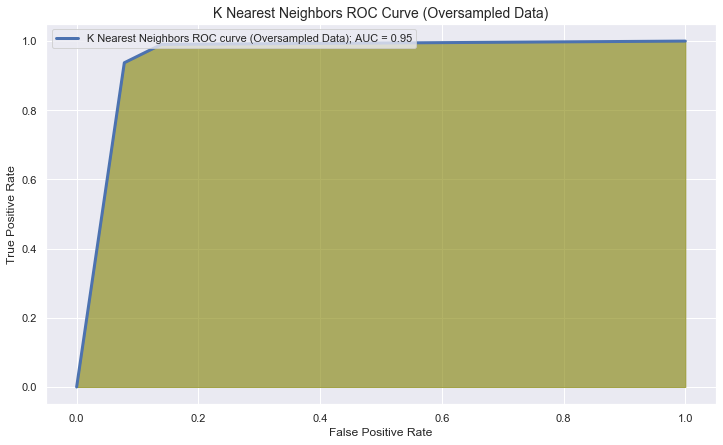

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_knn_over = best_knn_over.predict_proba(X_test_over)
knn_fpr_over, knn_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_knn_over[:,1])
knn_roc_auc_over = auc(knn_fpr_over, knn_tpr_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr_over, knn_tpr_over, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(knn_fpr_over, knn_tpr_over, linewidth=3, label='K Nearest Neighbors ROC curve (Oversampled Data); AUC = %0.2f' % knn_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors ROC Curve (Oversampled Data)', size=14)

#### Decision Tree Classifier ####

In [ ]:
# Classify with decision tree.

dt_over = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'splitter' : ['random','best' ]}
clf_dt_over = GridSearchCV(dt_over, parameters, cv=10)
clf_dt_over.fit(X_train_over, y_train_over)
best_dt_over = clf_dt_over.best_estimator_
y_hat_dt_over = best_dt_over.predict(X_test_over)
print(confusion_matrix(y_test_over, y_hat_dt_over, labels=[1,0]))

[[ 411    4]
 [  84 1014]]


In [ ]:
# Examine metrics.
y_hat_proba_dt_over = best_dt_over.predict_proba(X_test_over)
dt_fpr_over, dt_tpr_over, da_thresholds_over = roc_curve(y_test_over, y_hat_proba_dt_over[:,1])
dt_roc_auc_over = auc(dt_fpr_over, dt_tpr_over)
print('AUC: %0.2f' % dt_roc_auc_over)
print(classification_report(y_test_over, y_hat_dt_over))

AUC: 0.96
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1098
           1       0.83      0.99      0.90       415

    accuracy                           0.94      1513
   macro avg       0.91      0.96      0.93      1513
weighted avg       0.95      0.94      0.94      1513



Text(0.5, 1.0, 'Decision tree classification ROC Curve (Oversampled Data)')

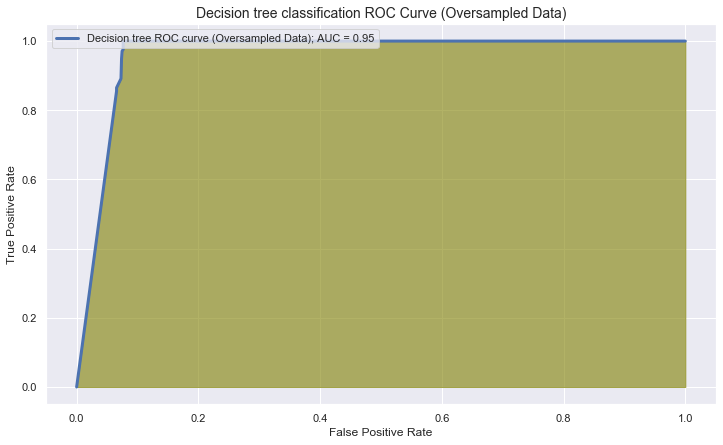

In [ ]:

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(dt_fpr_over, dt_tpr_over, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(dt_fpr_over, dt_tpr_over, linewidth=3, label='Decision tree ROC curve (Oversampled Data); AUC = %0.2f' % knn_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision tree classification ROC Curve (Oversampled Data)', size=14)

#### SVC #####

In [ ]:
# SVC on scaled, oversampled data.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_over = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_over.fit(X_train_over, y_train_over)
best_svc_over = clf_svc_over.best_estimator_
y_hat_svc_over = best_svc_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_svc_over, labels=[1,0])

array([[ 298,  117],
       [  68, 1030]])

In [ ]:
# Examine metrics.
y_hat_proba_svc_over = best_svc_over.predict_proba(X_test_over)
svc_fpr_over, svc_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_svc_over[:,1])
svc_roc_auc_over = auc(svc_fpr_over, svc_tpr_over)
print('AUC: %0.2f' % svc_roc_auc_over)
print(classification_report(y_test_over, y_hat_svc_over))

AUC: 0.93
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1098
           1       0.81      0.72      0.76       415

    accuracy                           0.88      1513
   macro avg       0.86      0.83      0.84      1513
weighted avg       0.88      0.88      0.88      1513



***Not bad either! This model takes some time to run but we're getting some pretty nice precision numbers on the positive class and our AUC is very good.***

Text(0.5, 1.0, 'SVC ROC Curve (Oversampled Data)')

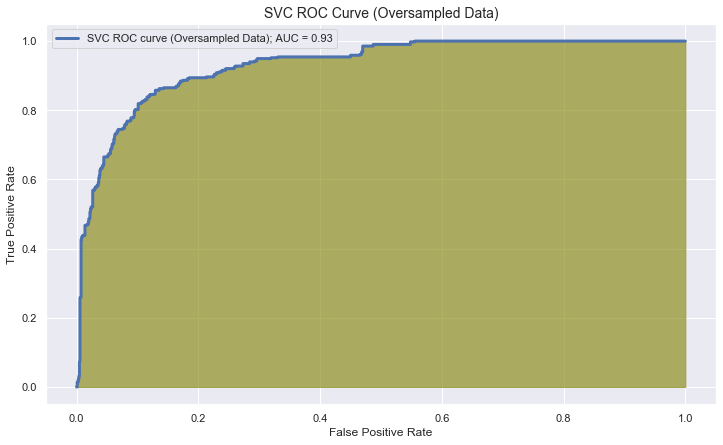

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_svc_over = best_svc_over.predict_proba(X_test_over)
svc_fpr_over, svc_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_svc_over[:,1])
svc_roc_auc_over = auc(svc_fpr_over, svc_tpr_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(svc_fpr_over, svc_tpr_over, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(svc_fpr_over, svc_tpr_over, linewidth=3, label='SVC ROC curve (Oversampled Data); AUC = %0.2f' % svc_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Oversampled Data)', size=14)

#### Classify with Random Forest.####

In [ ]:
# Classify with Random Forest.
from sklearn.ensemble import RandomForestClassifier
rf_over = RandomForestClassifier()
parameters = {'criterion': ['gini', 'entropy']}
clf_rf_over = GridSearchCV(rf_over, parameters, cv=10)
clf_rf_over.fit(X_train_over, y_train_over)
best_rf_over = clf_rf_over.best_estimator_
y_hat_rf_over = best_rf_over.predict(X_test_over)
print(confusion_matrix(y_test_over, y_hat_rf_over, labels=[1,0]))

[[ 411    4]
 [  50 1048]]


In [ ]:
# Examine metrics.
y_hat_proba_rf_over = best_rf_over.predict_proba(X_test_over)
rf_fpr_over, rf_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_rf_over[:,1])
rf_roc_auc_over = auc(rf_fpr_over, rf_tpr_over)
print('AUC: %0.2f' % rf_roc_auc_over)
print(classification_report(y_test_over, y_hat_rf_over))

AUC: 0.99
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1098
           1       0.89      0.99      0.94       415

    accuracy                           0.96      1513
   macro avg       0.94      0.97      0.96      1513
weighted avg       0.97      0.96      0.96      1513



Text(0.5, 1.0, 'Decision tree classification ROC Curve (Oversampled Data)')

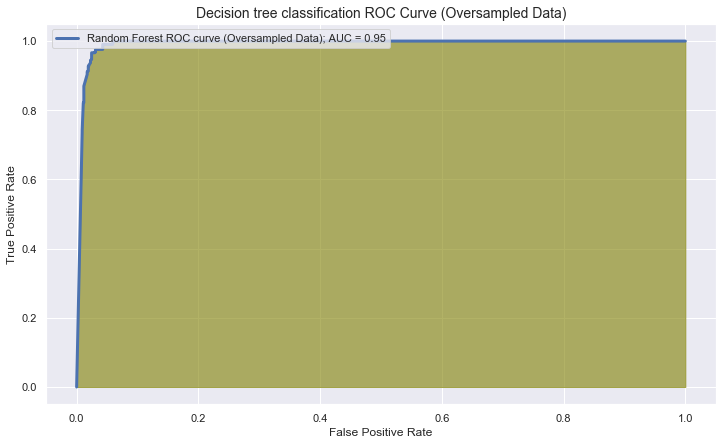

In [ ]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(rf_fpr_over, rf_tpr_over, 0, color='Olive', alpha=0.6)
ax1 = plt.plot(rf_fpr_over, rf_tpr_over, linewidth=3, label='Random Forest ROC curve (Oversampled Data); AUC = %0.2f' % knn_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision tree classification ROC Curve (Oversampled Data)', size=14)

### Removing Features with Less 'Signal' ###

Text(0.5, 1.0, 'Number of Zero Values by Feature')

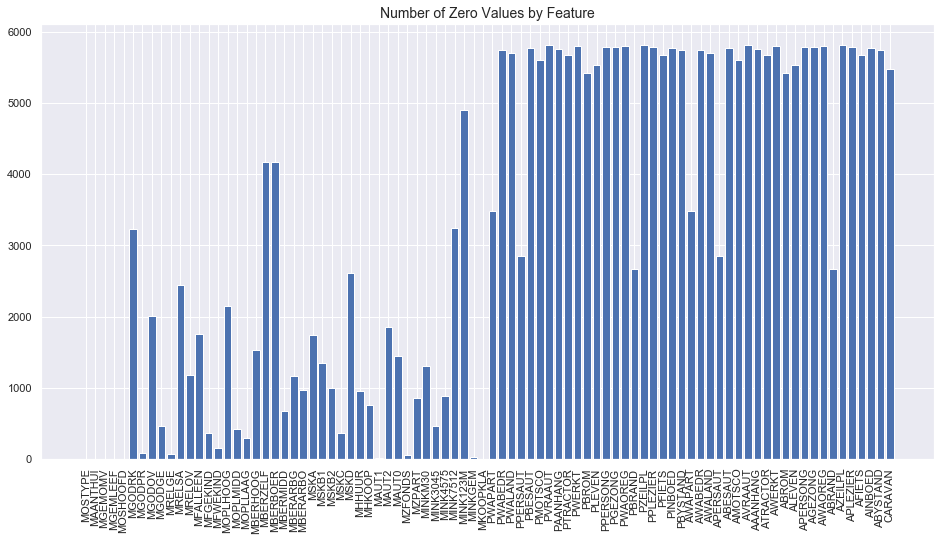

In [ ]:
# Recall which features have mostly 0 values.
num_zeros = []
for i in range(0, len(train.columns)):
    num_nonzero = len(train.iloc[:,i].nonzero()[0])
    num_zeros.append(train.shape[0] - num_nonzero)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = train.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Number of Zero Values by Feature', size=14)

Let's try removing every feature that has over 5000 `0s`.

In [ ]:
# Drop the columns.
signal_df = train.drop(['PWABEDR', 'PWALAND', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR',
                                 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PZEILPL', 'PPLEZIER',
                                  'PFIETS', 'PINBOED', 'PBYSTAND', 'AWABEDR', 'AWALAND', 'ABESAUT', 'AMOTSCO', 'AVRAAUT',
                                  'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG',
                                  'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND'], axis=1)

In [ ]:
# Check that columns were dropped.
signal_df.shape

(5822, 50)

Text(0.5, 1.0, 'Number of Zero Values by Feature')

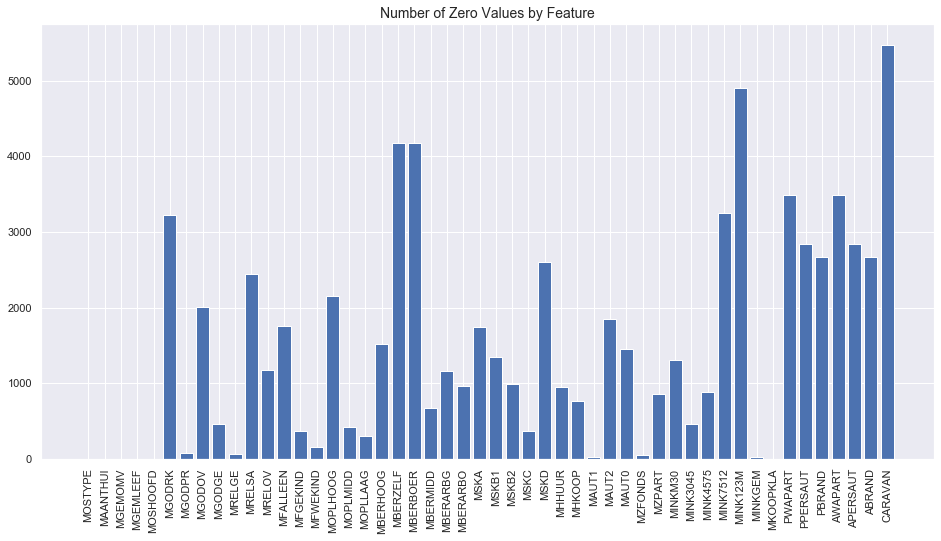

In [ ]:
# Look at 0 values for signal_df.
num_zeros = []
for i in range(0, len(signal_df.columns)):
    num_nonzero = len(signal_df.iloc[:,i].nonzero()[0])
    num_zeros.append(signal_df.shape[0] - num_nonzero)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = signal_df.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Number of Zero Values by Feature', size=14)

In [ ]:
# Multiply the number of positives by 6. We'll then add to the original database for 7x total positives.
positives = signal_df[signal_df['CARAVAN'] == 1]
for _ in range(4):
    positives = positives.append(signal_df[signal_df['CARAVAN'] == 1])

In [ ]:
# Append negatives.
oversample_signal_df = signal_df.append(positives).sample(frac=1).reset_index(drop=True)

In [ ]:
# Check size of new dataset.
oversample_signal_df.shape

(7562, 50)

In [ ]:
# Check ratio of label values.
oversample_signal_df['CARAVAN'].value_counts()

0    5474
1    2088
Name: CARAVAN, dtype: int64

In [ ]:
# Split data into X and y.
X_signal_over = oversample_signal_df.drop(['CARAVAN'], axis=1).values
y_signal_over = oversample_signal_df['CARAVAN'].factorize()[0]

In [ ]:
# Normalize the data.
scaler = StandardScaler()
X_signal_scaled_over = scaler.fit_transform(X_signal_over)

In [ ]:
# Train test split.
X_train_ss_over, X_test_ss_over, y_train_ss_over, y_test_ss_over = train_test_split(X_signal_scaled_over, y_signal_over, 
                                                                                    test_size=0.20, random_state=9)

##### Logistic Regression #####

In [ ]:
# Logistic regression with fewer features, oversampled.
lr_signal_over = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_signal_over = GridSearchCV(lr_signal_over, parameters, cv=10)
clf_lr_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_lr_signal_over = clf_lr_signal_over.best_estimator_
y_hat_lr_signal_over = best_lr_signal_over.predict(X_test_ss_over)
print(confusion_matrix(y_test_ss_over, y_hat_lr_signal_over, labels=[1,0]))

[[1020  100]
 [ 258  135]]


In [ ]:
# Examine metrics.
y_hat_proba_lr_signal_over = best_lr_signal_over.predict_proba(X_test_ss_over)
lr_fpr_signal_over, lr_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_lr_signal_over[:,1])
lr_roc_auc_signal_over = auc(lr_fpr_signal_over, lr_tpr_signal_over)
print('AUC: %0.2f' % lr_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_lr_signal_over))

AUC: 0.77
              precision    recall  f1-score   support

           0       0.57      0.34      0.43       393
           1       0.80      0.91      0.85      1120

    accuracy                           0.76      1513
   macro avg       0.69      0.63      0.64      1513
weighted avg       0.74      0.76      0.74      1513



***This might be our best Logistic Regression model yet, at least for predicting elements of the positive class. Let's look at the others.***

##### K-NN #####

In [ ]:
# K-NN with fewer features, oversampled.
knn_signal_over = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_signal_over = GridSearchCV(knn_signal_over, parameters, cv=10)
clf_knn_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_knn_signal_over = clf_knn_signal_over.best_estimator_
y_hat_knn_signal_over = best_knn_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_knn_signal_over, labels=[1,0])

array([[968, 152],
       [  1, 392]])

In [ ]:
# Examine metrics.
y_hat_proba_knn_signal_over = best_knn_signal_over.predict_proba(X_test_ss_over)
knn_fpr_signal_over, knn_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_knn_signal_over[:,1])
knn_roc_auc_signal_over = auc(knn_fpr_signal_over, knn_tpr_signal_over)
print('AUC: %0.2f' % knn_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_knn_signal_over))

AUC: 0.96
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       393
           1       1.00      0.86      0.93      1120

    accuracy                           0.90      1513
   macro avg       0.86      0.93      0.88      1513
weighted avg       0.93      0.90      0.90      1513



***This model rivals our straight over sampled model.***

Text(0.5, 1.0, 'K-NN ROC Curve (Fewer Features, Oversampled)')

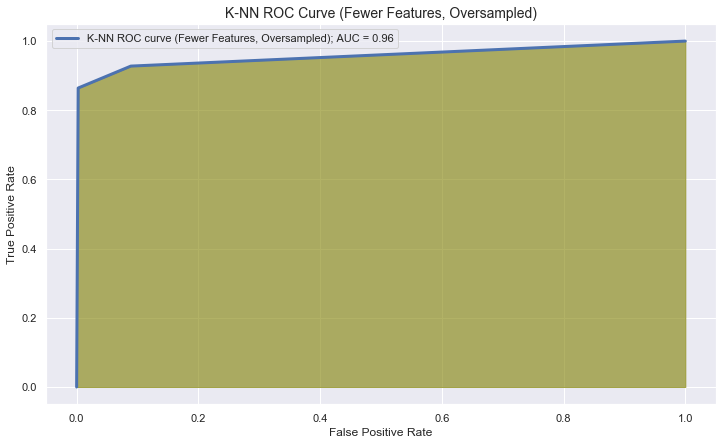

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_knn_signal_over = best_knn_signal_over.predict_proba(X_test_ss_over)
knn_fpr_signal_over, knn_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_knn_signal_over[:,1])
knn_roc_auc_signal_over = auc(knn_fpr_signal_over, knn_tpr_signal_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr_signal_over, knn_tpr_signal_over, 0, color='olive', alpha=0.6)
ax1 = plt.plot(knn_fpr_signal_over, knn_tpr_signal_over, linewidth=3, label='K-NN ROC curve (Fewer Features, Oversampled); AUC = %0.2f' % knn_roc_auc_signal_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-NN ROC Curve (Fewer Features, Oversampled)', size=14)

### Classify with Suppoer Vector Classification after signal elimination###

In [ ]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_signal_over = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_svc_signal_over = clf_svc_signal_over.best_estimator_
y_hat_svc_signal_over = best_svc_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_svc_signal_over, labels=[1,0])

array([[1005,  115],
       [  74,  319]])

In [ ]:
# Examine metrics.
y_hat_proba_svc_signal_over = best_svc_signal_over.predict_proba(X_test_ss_over)
svc_fpr_signal_over, svc_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_svc_signal_over[:,1])
svc_roc_auc_signal_over = auc(svc_fpr_signal_over, svc_tpr_signal_over)
print('AUC: %0.2f' % svc_roc_auc_signal_over)

print(classification_report(y_test_ss_over, y_hat_svc_signal_over))

AUC: 0.93
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       393
           1       0.93      0.90      0.91      1120

    accuracy                           0.88      1513
   macro avg       0.83      0.85      0.84      1513
weighted avg       0.88      0.88      0.88      1513



Text(0.5, 1.0, 'SVC ROC Curve (Fewer Features, Oversampled)')

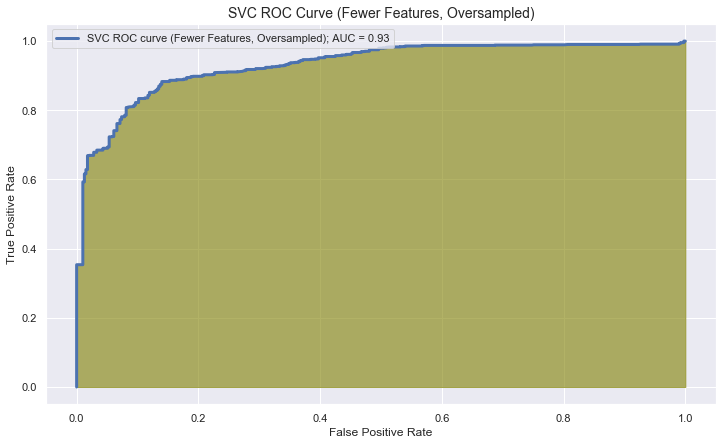

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_svc_signal_over = best_svc_signal_over.predict_proba(X_test_ss_over)
svc_fpr_signal_over, svc_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_svc_signal_over[:,1])
svc_roc_auc_signal_over = auc(svc_fpr_signal_over, svc_tpr_signal_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(svc_fpr_signal_over, svc_tpr_signal_over, 0, color='olive', alpha=0.6)
ax1 = plt.plot(svc_fpr_signal_over, svc_tpr_signal_over, linewidth=3, label='SVC ROC curve (Fewer Features, Oversampled); AUC = %0.2f' % svc_roc_auc_signal_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Fewer Features, Oversampled)', size=14)

### Classify with decision tree after eliminating signal ###

In [ ]:
# Classify with decision tree.

dt_signal_over = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'splitter' : ['random','best' ]}
clf_dt_signal_over = GridSearchCV(dt_signal_over, parameters, cv=10)
clf_dt_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_dt_signal_over = clf_dt_signal_over.best_estimator_
y_hat_dt_signal_over = best_dt_signal_over.predict(X_test_ss_over)
print(confusion_matrix(y_test_over, y_hat_dt_over, labels=[1,0]))

[[ 411    4]
 [  84 1014]]


In [ ]:
# Examine metrics.
y_hat_proba_dt_signal_over = best_dt_signal_over.predict_proba(X_test_ss_over)
dt_fpr_signal_over, dt_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_dt_signal_over[:,1])
dt_roc_auc_signal_over = auc(dt_fpr_signal_over, dt_tpr_signal_over)
print('AUC: %0.2f' % dt_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_dt_signal_over))

AUC: 0.95
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       393
           1       1.00      0.90      0.95      1120

    accuracy                           0.93      1513
   macro avg       0.89      0.95      0.91      1513
weighted avg       0.94      0.93      0.93      1513



Text(0.5, 1.0, 'Decision tree ROC Curve (Fewer Features, Oversampled)')

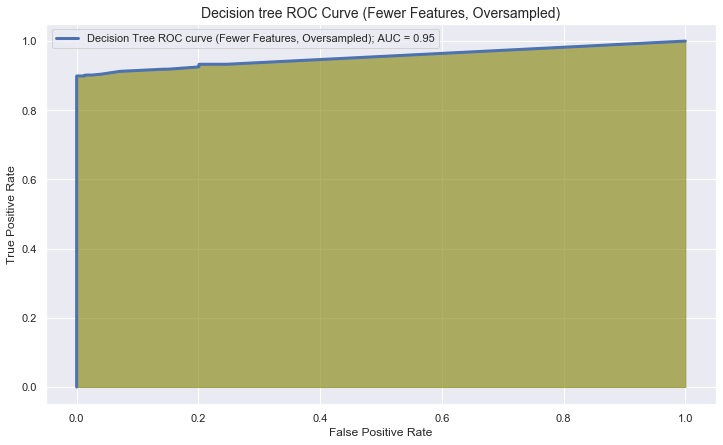

In [ ]:
# Examine ROC curve and AUC.
y_hat_proba_dt_signal_over = best_dt_signal_over.predict_proba(X_test_ss_over)
dt_fpr_signal_over, dt_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_dt_signal_over[:,1])
dt_roc_auc_signal_over = auc(dt_fpr_signal_over, dt_tpr_signal_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(dt_fpr_signal_over, dt_tpr_signal_over, 0, color='olive', alpha=0.6)
ax1 = plt.plot(dt_fpr_signal_over, dt_tpr_signal_over, linewidth=3, label='Decision Tree ROC curve (Fewer Features, Oversampled); AUC = %0.2f' % dt_roc_auc_signal_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision tree ROC Curve (Fewer Features, Oversampled)', size=14)

### Classify with Random Forest after signal minimization ###

In [ ]:
# Classify with Random Forest.
rf_ss_over = RandomForestClassifier()
parameters = {'criterion': ['gini', 'entropy']}
clf_rf_ss_over = GridSearchCV(rf_ss_over, parameters, cv=10)
clf_rf_ss_over.fit(X_train_ss_over, y_train_ss_over)
best_rf_ss_over = clf_rf_ss_over.best_estimator_
y_hat_rf_ss_over = best_rf_ss_over.predict(X_test_ss_over)
print(confusion_matrix(y_test_ss_over, y_hat_rf_ss_over, labels=[1,0]))

[[1052   68]
 [   1  392]]


In [ ]:
# Examine metrics.
y_hat_proba_rf_ss_over = best_rf_ss_over.predict_proba(X_test_ss_over)
rf_fpr_ss_over, rf_tpr_ss_over, thresholds_over = roc_curve(y_test_ss_over, y_hat_proba_rf_ss_over[:,1])
rf_roc_auc_ss_over = auc(rf_fpr_ss_over, rf_tpr_ss_over)
print('AUC: %0.2f' % rf_roc_auc_ss_over)
print(classification_report(y_test_ss_over, y_hat_rf_ss_over))

AUC: 0.99
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       393
           1       1.00      0.94      0.97      1120

    accuracy                           0.95      1513
   macro avg       0.93      0.97      0.94      1513
weighted avg       0.96      0.95      0.96      1513



***This is a great model. We have high AUC, high metrics for our positive class, and a large number of correctly classified positives.***

***Overall, while over sampling seems to have been our single most successful technique for getting a good AUC score alongside good metrics, combining over sampling with removing features with little signal allowed us to dramatically increase the number of correctly classified positives, which was ultimately our goal.***